# 1. Preparación de entorno


In [ ]:
# Instalacion de librerias
!pip install -q timm

# Imports
import os
import glob
import shutil
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import timm
import torch.nn.functional as F


#2. HAM10000

In [ ]:
# Configuracion Drive
from google.colab import drive
drive.mount('/content/drive')

# carpeta de checkpoints
CHECKPOINT_DIR = "/content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

if not os.path.exists('/content/data'):
    print("Descomprimiendo dataset...")
    !mkdir -p /content/data
    !unzip -q -o '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000.zip' -d /content/data

# Unir HAM10000
img_dir = '/content/data/all_images'
os.makedirs(img_dir, exist_ok=True)

for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    source_dir = os.path.join('/content/data', part)
    if os.path.exists(source_dir):
        for file_name in os.listdir(source_dir):
            shutil.move(os.path.join(source_dir, file_name), os.path.join(img_dir, file_name))

Mounted at /content/drive
Descomprimiendo dataset...


#3. Modulo de denoising

In [ ]:
'''
DenoisingModule1: Implementación del modulo de Denoising
                  Encoder-Decoder sin pooling para preservar detalles espaciales
                  reducida para memoria
  ENTRADA:
    sin argumentos, define las capas internas
  SALIDA:
    Instancia del modelo nn.Module lista para forward
'''
class DenoisingModule1(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 64, 3, padding=1)
        # Decoder
        self.dec1 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec2 = nn.ConvTranspose2d(64, 3, 3, padding=1)
        self.relu = nn.ReLU()

    '''
    forward: Ejecuta el paso de codificación y decodificación.
             skip connection para restaurar detalles perdidos.
      ENTRADA:
        x: tensor de imagen con ruido (Batch, 3, Alto, Ancho)
      SALIDA:
        out: tensor de imagen limpia (Batch, 3, Alto, Ancho)
    '''
    def forward(self, x):
        # Encoder
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(e1))

        # Decoder + Skip connection
        # Se suma e1 (detalles de bajo nivel) a la salida de la primera deconvolucion
        d1 = self.relu(self.dec1(e2) + e1)
        out = self.dec2(d1)
        return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

'''
DenoisingModule: Implementación COMPLETA del Denoising Module (Fig 3 del paper).
                 Estructura Encoder-Decoder de 5 capas sin pooling.
                 Utiliza skip connections simétricas y una conexión residual final.
  ENTRADA:
    sin argumentos, define las capas internas
  SALIDA:
    Instancia del modelo nn.Module lista para forward
'''
class DenoisingModule(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Encoder (5 Capas) ---
        self.enc1 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc3 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc4 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc5 = nn.Conv2d(64, 64, 3, padding=1) # Capa más profunda

        # --- Decoder (5 Capas Transpuestas) ---
        self.dec1 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec2 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec3 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.dec4 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        # ultima capa vuelve a 3 canales (para el mapa residual)
        self.dec5 = nn.ConvTranspose2d(64, 3, 3, padding=1)

        self.relu = nn.ReLU()

    '''
    forward: Ejecuta el flujo de datos según la Fig 3 (con 4 skip connections + 1 residual).
      ENTRADA:
        x: tensor de imagen con ruido (Batch, 3, Alto, Ancho)
      SALIDA:
        out: tensor de imagen limpia (Batch, 3, Alto, Ancho)
    '''
    def forward(self, x):
        # --- Encoder ---
        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(e1))
        e3 = self.relu(self.enc3(e2))
        e4 = self.relu(self.enc4(e3))
        e5 = self.relu(self.enc5(e4))

        # --- Decoder + Skip Connections  ---
        # d1 usa e5 (sin skip)
        d1 = self.relu(self.dec1(e5))
        # d2 usa d1 + e4
        d2 = self.relu(self.dec2(d1 + e4))
        # d3 usa d2 + e3
        d3 = self.relu(self.dec3(d2 + e3))
        # d4 usa d3 + e2
        d4 = self.relu(self.dec4(d3 + e2))

        # salida del decoder (el mapa de ruido/residual)
        residual_map = self.dec5(self.relu(d4 + e1))

        # --- Conexion residual final ---
        # Y = X + F(X)
        # salida limpia entrada 'x' + el mapa de ruido aprendido
        out = x + residual_map
        return out

#4. MS_CAM

In [ ]:
'''
MS_CAM: Implementación de Multi-Scale Channel Attention Module
        Calcula pesos de atención combinando contextos globales (con Pooling)
        y locales (con Convolucion punto a punto).
  ENTRADA:
    channels: entero, dimensión de canales del mapa de características
    r: entero, factor de reducción para el cuello de botella (default=4)
  SALIDA:
    Instancia del módulo lista para forward.
'''
class MS_CAM(nn.Module):
    def __init__(self, channels, r=4):
        super().__init__()
        inter_channels = int(channels // r)

        # Global Feature Attention
        # Global Average Pooling seguido de PWConv
        self.global_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(),
            nn.Conv2d(inter_channels, channels, kernel_size=1),
            nn.BatchNorm2d(channels)
        )

        # Local Feature Attention
        # solo PWConv sin pooling para preservar detalle espacial
        self.local_att = nn.Sequential(
            nn.Conv2d(channels, inter_channels, kernel_size=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(),
            nn.Conv2d(inter_channels, channels, kernel_size=1),
            nn.BatchNorm2d(channels)
        )

        self.sigmoid = nn.Sigmoid()

    '''
    forward: Genera los pesos de atención (alpha) sumando ramas global y local.
             M(X) = Sigmoid(L(X) + g(X)) según Ec. 5 del paper.
      ENTRADA:
        x: tensor de características (Batch, Channels, Alto, Ancho)
      SALIDA:
        w: tensor de pesos de atención (Batch, Channels, Alto, Ancho)
           con valores en rango [0, 1]
    '''
    def forward(self, x):
        g = self.global_att(x) # Rama global (Broadcasting de 1x1 a HxW)
        l = self.local_att(x)  # Rama local
        w = self.sigmoid(g + l)
        return w

#5. AFF

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# =========================
# MODULO AFF
# =========================
'''
AFF: Fusiona X (local) e Y (global) usando pesos dinámicos (alpha).
     Alpha se genera combinando X e Y con Cat -> ChannelShuffle -> Conv -> MS-CAM.
  ENTRADA:
    channels: entero, número de canales de X e Y (ej. 192, 384...)
    r: entero, factor de reducción para el módulo interno MS-CAM (default=4)
    groups: entero, número de grupos para el channel shuffle (default=2)
  SALIDA:
    Instancia del módulo AFF lista para forward.
'''
class AFF(nn.Module):
    def __init__(self, channels, r=4, groups=2):
        super().__init__()

        # Capa de Convolucion 1x1 (bloque Conv)
        # reduce la entrada concatenada (2*channels) a (channels)
        self.conv_after_cat = nn.Conv2d(2 * channels, channels, kernel_size=1)

        # Modulo de Atencion (bloque 'MS-CAM')
        self.mscam = MS_CAM(channels, r)

        # Grupos para el Channel Shuffle
        self.groups = groups

    '''
    _channel_shuffle: Reordena los canales para mezclar información entre grupos.
      ENTRADA:
        x: tensor (Batch, Canales_Concatenados, Alto, Ancho)
        groups: número de grupos a mezclar
      SALIDA:
        tensor barajado (Batch, Canales_Concatenados, Alto, Ancho)
    '''
    def _channel_shuffle(self, x, groups):
        b, c, h, w = x.data.size()
        channels_per_group = c // groups

        # Reshape -> Transpose -> Reshape (logica estandar de ShuffleNet)
        x = x.view(b, groups, channels_per_group, h, w)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(b, c, h, w)
        return x

    '''
    forward: Ejecuta la fusión adaptativa de las entradas según la Fig 5.
      ENTRADA:
        x: tensor de características locales (ConvNeXt) -> (B, C, H, W)
        y: tensor de características globales (Swin) -> (B, C, H, W)
      SALIDA:
        z: tensor de características fusionadas -> (B, C, H, W)
    '''
    def forward(self, x, y):
        # x: ConvNeXt features (Local)
        # y: Swin features (Global)

        # --- 1. Alineacion ---
        if x.size() != y.size():
            y = F.interpolate(y, size=x.shape[2:], mode='bilinear', align_corners=False)

        # --- 2. Fusion inicial  ---

        # 2a. Concatenar (Cat)
        xy_concatenated = torch.cat((x, y), dim=1) # Forma: (B, 2*C, H, W)

        # 2b. Channel Shuffle
        # groups=2 para mezclar la info de la rama X y la rama Y
        xy_shuffled = self._channel_shuffle(xy_concatenated, self.groups)

        # 2c. Convolución 1x1 (Conv)
        # Reduce de 2*C de nuevo a C
        initial_fused_features = self.conv_after_cat(xy_shuffled) # Forma: (B, C, H, W)

        # 3. Generación de Pesos (MS-CAM)
        # Se alimenta el resultado de la fusion al MS-CAM
        weights = self.mscam(initial_fused_features) # 'alpha'

        # 4. Fusion Ponderada Final
        # Z = alpha * X + (1 - alpha) * Y
        z = weights * x + (1 - weights) * y
        return z

#6. ConvNeXt_ST_AFF

## 6.1. ECA

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import math

# =========================
# MODULO DE ATENCION (ECA)
# =========================
'''
ECA: Modulo Efficient Channel Attention.
     Calcula la atención de canal usando GAP y una Conv1D adaptativa.
  ENTRADA:
    channel: entero, número de canales de la entrada.
    b, gamma: parámetros para calcular el tamaño del kernel adaptativo.
  SALIDA:
    Instancia del modulo ECA.
'''
class ECA(nn.Module):
    def __init__(self, channel, b=1, gamma=2):
        super().__init__()

        # Calcula el tamaño del kernel adaptativo (k_size) según el paper de ECA
        # k = | (log2(C) + b) / gamma | impar
        k_size = int(abs((math.log(channel, 2) + b) / gamma)) * 2 + 1

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    '''
    forward: Aplica la atención al tensor de entrada.
      ENTRADA:
        x: tensor (Batch, Channels, Alto, Ancho)
      SALIDA:
        out: tensor (Batch, Channels, Alto, Ancho) con atención aplicada
    '''
    def forward(self, x):
        # x tiene forma (B, C, H, W)

        # 1. Global Average Pooling
        y = self.avg_pool(x) # (B, C, 1, 1)

        # 2. Conv1d
        # Para usar Conv1d se necesita (B, 1, C)
        y = y.squeeze(-1).permute(0, 2, 1) # (B, 1, C)
        y = self.conv(y)                   # (B, 1, C)
        y = y.permute(0, 2, 1).unsqueeze(-1) # (B, C, 1, 1)

        # 3. Sigmoid
        y = self.sigmoid(y) # Pesos de atención 'alpha'

        # 4. Multiplicar pesos por la entrada original
        return x * y.expand_as(x)

##6.2. ConvNeXt con ECA (personalizado)

In [ ]:
# =========================
# BLOQUE CONVNEXT PERSONALIZADO (con ECA) - CORRECCIÓN DEFINITIVA
# =========================
'''
CustomConvNeXtBlock: Envuelve un bloque ConvNeXt de TIMM e inyecta ECA.
                     Maneja la permutación de tensores necesaria para
                     LayerNorm (norm) y Mlp (mlp) y LayerScale (gamma).
  ENTRADA:
    block: el bloque original pre-entrenado de timm.
    eca_channel: el número de canales para inicializar ECA.
  SALIDA:
    Instancia del bloque modificado.
'''
class CustomConvNeXtBlock(nn.Module):
    def __init__(self, block, eca_channel):
        super().__init__()
        # Tomar las capas pre-entrenadas
        self.dwconv = block.conv_dw   # Espera (B, C, H, W)
        self.norm = block.norm        # Espera (B, H, W, C)
        self.mlp = block.mlp          # Espera (B, H, W, C)
        self.gamma = block.gamma      # nn.Parameter
        self.drop_path = block.drop_path

        # Añadir modulo ECA
        self.eca = ECA(channel=eca_channel) # Espera (B, C, H, W)

    '''
    forward: permutaciones necesarias ANTES y DESPUÉS de norm/mlp.
    '''
    def forward(self, x):
        # x entra como (B, C, H, W)
        shortcut = x

        x = self.dwconv(x) # (B, C, H, W)

        # --- CORRECCION DE FORMATO ---
        # Permutar (B, C, H, W) -> (B, H, W, C) para LayerNorm y MLP
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.mlp(x)
        # mlp devuelve (B, H, W, C)

        if self.gamma is not None:
            # nn.Parameter se multiplica, no se llama
            x = x * self.gamma

        # Permutar (B, H, W, C) -> (B, C, H, W) para ECA y la conexión residual
        x = x.permute(0, 3, 1, 2)

        # --- INYECCIÓN DE ECA ---
        x = self.eca(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        # Conexion residual
        x = x + shortcut
        return x

##6.2. Modelo Híbrido

In [ ]:
# =========================
# MODELO HÍBRIDO: ConvNeXt-ST-AFF
# =========================
class ConvNeXt_ST_AFF(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        # --- 1. Modulo de Denoising ---
        self.denoising = DenoisingModule()

        # --- 2. Cargar Backbones Completos ---
        convnext_base = timm.create_model('convnext_tiny', pretrained=True)
        swin_base = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

        c_dims = [info['num_chs'] for info in convnext_base.feature_info] # [96, 192, 384, 768]

        # --- 3. Tomar y modificar Bloques de ConvNeXt con ECA ---
        self.convnext_stem = convnext_base.stem
        # Stage 1
        stage1_blocks = []
        for block in convnext_base.stages[0].blocks:
            stage1_blocks.append(CustomConvNeXtBlock(block, eca_channel=c_dims[0])) # Usa el bloque corregido
        self.convnext_stage1 = nn.Sequential(*stage1_blocks)
        # Stage 2
        self.convnext_downsample2 = convnext_base.stages[1].downsample
        stage2_blocks = []
        for block in convnext_base.stages[1].blocks:
            stage2_blocks.append(CustomConvNeXtBlock(block, eca_channel=c_dims[1]))
        self.convnext_stage2 = nn.Sequential(*stage2_blocks)
        # Stage 3
        self.convnext_downsample3 = convnext_base.stages[2].downsample
        stage3_blocks = []
        for block in convnext_base.stages[2].blocks:
            stage3_blocks.append(CustomConvNeXtBlock(block, eca_channel=c_dims[2]))
        self.convnext_stage3 = nn.Sequential(*stage3_blocks)
        # Stage 4
        self.convnext_downsample4 = convnext_base.stages[3].downsample
        stage4_blocks = []
        for block in convnext_base.stages[3].blocks:
            stage4_blocks.append(CustomConvNeXtBlock(block, eca_channel=c_dims[3]))
        self.convnext_stage4 = nn.Sequential(*stage4_blocks)

        # --- 4. Tomar Bloques de Swin Transformer ---
        self.swin_patch_embed = swin_base.patch_embed
        self.swin_stage1 = swin_base.layers[0]
        self.swin_patchmerge2 = swin_base.layers[1].downsample # Espera (B, H, W, C)
        self.swin_stage2 = swin_base.layers[1].blocks
        self.swin_patchmerge3 = swin_base.layers[2].downsample # Espera (B, L, C)
        self.swin_stage3 = swin_base.layers[2].blocks
        self.swin_patchmerge4 = swin_base.layers[3].downsample # Espera (B, L, C)
        self.swin_stage4 = swin_base.layers[3].blocks

        # --- 5. Modulos de Fusion (AFF) - 4 Etapas ---
        self.aff0 = AFF(c_dims[0])
        self.aff1 = AFF(c_dims[1])
        self.aff2 = AFF(c_dims[2])
        self.aff3 = AFF(c_dims[3])

        # --- 6. Cabezal de Clasificacion (Head) ---
        self.head_norm = convnext_base.head.norm
        self.head_pool = nn.AdaptiveAvgPool2d(1)
        self.head_linear = nn.Linear(c_dims[3], num_classes)

        del convnext_base
        del swin_base

    '''
    _reshape_swin_to_4d: Convierte (B, L, C) -> (B, C, H, W)
    '''
    def _reshape_swin_to_4d(self, swin_tensor, conv_tensor):
      # conv_tensor viene del branch ConvNeXt: (B, C, H, W)
      B, C, H, W = conv_tensor.shape

      if swin_tensor.dim() == 3:
          # swin_tensor: (B, L, C)  ->  (B, C, H, W)
          B_s, L, C_s = swin_tensor.shape
          assert B_s == B, "Batch de Swin y ConvNeXt no coincide"
          # aquí C_s debería ser igual a C (o puedes proyectar)
          swin_reshaped = swin_tensor.permute(0, 2, 1).reshape(B, C_s, H, W)

      elif swin_tensor.dim() == 4:
          # Puede venir como (B, H, W, C) o ya como (B, C, H, W)
          if swin_tensor.shape[1:3] == (H, W):
              # (B, H, W, C) -> (B, C, H, W)
              swin_reshaped = swin_tensor.permute(0, 3, 1, 2)
          elif swin_tensor.shape[2:4] == (H, W):
              # ya está en (B, C, H, W)
              swin_reshaped = swin_tensor
          else:
              raise ValueError(f"Forma inesperada de swin_tensor: {swin_tensor.shape}")
      else:
          raise ValueError(f"Esperaba tensor 3D o 4D, pero recibí {swin_tensor.dim()}D")

      return swin_reshaped


    '''
    forward: Define el flujo de datos INTERACTIVO
             Maneja los cambios de formato de Swin (B,H,W,C) y (B,L,C)
    '''
    def forward(self, x):
        # 1. Denoising
        x = self.denoising(x)

        # --- ETAPA 1 (Dims=dim, 56x56) ---
        c_out = self.convnext_stem(x)
        c_out = self.convnext_stage1(c_out) # (B, 96, 56, 56) [B,C,H,W]

        # PatchEmbed devuelve (B, L, C) -> (B, 3136, 96)
        s_out_3d = self.swin_patch_embed(x)
        s_out_stage1 = self.swin_stage1(s_out_3d) # (B, 3136, 96) [B,L,C]

        # Reformatear s_out de 3D a 4D para AFF
        s_out_reshaped = self._reshape_swin_to_4d(s_out_stage1, c_out)
        fused_out_1 = self.aff0(c_out, s_out_reshaped) # (B, 96, 56, 56)

        # --- ETAPA 2 (Dims=dim*2, 28x28) ---
        # PatchMerge (downsample) espera (B, L, C)
        s_in_2 = self.swin_patchmerge2(s_out_stage1) # (B, 784, 192) [B,L,C]
        s_out_stage2 = self.swin_stage2(s_in_2)      # (B, 784, 192) [B,L,C]

        c_in_2 = self.convnext_downsample2(fused_out_1) # <- Fusion Interactiva
        c_out = self.convnext_stage2(c_in_2)           # (B, 192, 28, 28) [B,C,H,W]

        # Reformatear s_out de 3D a 4D
        s_out_reshaped = self._reshape_swin_to_4d(s_out_stage2, c_out)
        fused_out_2 = self.aff1(c_out, s_out_reshaped) # (B, 192, 28, 28)

        # --- ETAPA 3 (Dims=dim*4, 14x14) ---
        s_in_3 = self.swin_patchmerge3(s_out_stage2) # s_out ya está en (B, L, C)
        s_out_stage3 = self.swin_stage3(s_in_3)      # (B, 196, 384) [B,L,C]

        c_in_3 = self.convnext_downsample3(fused_out_2) # <- Fusión Interactiva
        c_out = self.convnext_stage3(c_in_3)            # (B, 384, 14, 14) [B,C,H,W]

        # Reformatear s_out de 3D a 4D
        s_out_reshaped = self._reshape_swin_to_4d(s_out_stage3, c_out)
        fused_out_3 = self.aff2(c_out, s_out_reshaped) # (B, 384, 14, 14)

        # --- ETAPA 4 (Dims=dim*8, 7x7) ---
        s_in_4 = self.swin_patchmerge4(s_out_stage3)
        s_out_stage4 = self.swin_stage4(s_in_4) # (B, 49, 768) [B,L,C]

        c_in_4 = self.convnext_downsample4(fused_out_3) # <- Fusión Interactiva
        c_out = self.convnext_stage4(c_in_4)            # (B, 768, 7, 7) [B,C,H,W]

        # Reformatear s_out de 3D a 4D
        s_out_reshaped = self._reshape_swin_to_4d(s_out_stage4, c_out)
        fused_out_4 = self.aff3(c_out, s_out_reshaped) # (B, 768, 7, 7)

        # --- 5. Cabezal de Clasificación ---
        out = self.head_norm(fused_out_4)
        out = self.head_pool(out)
        out = out.flatten(start_dim=1)
        out = self.head_linear(out)

        return out

#7. Modelos individuales

In [ ]:
# obtener modelos individuales
def get_convnext_standalone(num_classes=7):
    model = timm.create_model('convnext_tiny', pretrained=True, num_classes=num_classes)
    return model

def get_swin_standalone(num_classes=7):
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
    return model

#8. Data augmentation

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

# =========================
# DATASET HAM10000 (Sin cambios)
# =========================
'''
HAM10000Dataset: Clase Dataset para cargar imagenes de HAM10000
                 Mapea las etiquetas de texto a índices numéricos y aplica transformaciones
  ENTRADA:
    df: DataFrame de pandas con metadatos (con 'image_id' y 'dx').
    img_dir: ruta al directorio que contiene las imágenes .jpg.
    transform: composición de transformaciones de torchvision a aplicar.
  SALIDA:
    Objeto Dataset iterable compatible con DataLoader.
'''
class HAM10000Dataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

        # Mapeo de clases a índices numéricos
        self.label_map = {
            'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3,
            'akiec': 4, 'vasc': 5, 'df': 6
        }

    def __len__(self):
        return len(self.df)

    '''
    __getitem__: Carga una imagen y su etiqueta dado un índice.
      ENTRADA:
        idx: entero, índice del elemento a recuperar.
      SALIDA:
        Tupla (image, label) donde image es un tensor y label un tensor Long.
    '''
    def __getitem__(self, idx):
        # Construir ruta de imagen
        img_id = self.df.iloc[idx]['image_id']
        img_name = f"{img_id}.jpg"
        img_path = os.path.join(self.img_dir, img_name)

        # Cargar y convertir imagen
        image = Image.open(img_path).convert('RGB')

        # Obtener etiqueta numérica
        label_str = self.df.iloc[idx]['dx']
        label = self.label_map[label_str]

        # Aplicar transformaciones si existen
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# =========================
# PREPARACIÓN DE DATALOADERS
# =========================
'''
get_dataloaders: Prepara los DataLoaders para Entrenamiento, Validación y Test.
                 Realiza el split 60/20/20 y configura las transformaciones según el escenario.
  ENTRADA:
    augment_scenario: string, define la estrategia de aumento (todos los conjuntos o solo entrenamiento).
    batch_size: entero, tamaño del batch para el entrenamiento (default=32).
  SALIDA:
    loaders: diccionario con claves ['train', 'val', 'test'] conteniendo los DataLoaders.
'''
def get_dataloaders(augment_scenario="train_only", batch_size=32):
    # Leer CSV de metadatos
    df = pd.read_csv('/content/data/HAM10000_metadata.csv')

    # --- SPLITTING 60/20/20 ---
    # (Division estratificada 60/20/20)
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['dx'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df['dx'])
    print(f"Split Sizes -> Train: {len(train_df)} (60%), Val: {len(val_df)} (20%), Test: {len(test_df)} (20%)")

    # --- GUARDAR PARTICION ---
    split_df = pd.concat([
        train_df.assign(split="train"),
        val_df.assign(split="val"),
        test_df.assign(split="test")
    ], ignore_index=True)

    split_df[['image_id', 'dx', 'split']].to_csv(
    '/content/drive/MyDrive/ucsp/implementacion_articulo/split_hibrido_60_20_20.csv',
    index=False
    )
    #print("Archivo de split guardado en /content/drive/MyDrive/ucsp/implementacion_articulo/split_hibrido_60_20_20.csv")


    # --- TRANSFORMACIONES ---

    # Transformación de TRAINING
    train_transform = transforms.Compose([
        # (1) "randomly cropped... resized to 224x224"
        # mas potente que solo Resize, tambien hace zoom aleatorio
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

        # (2) "RandAugment method... two randomly selected augmentations"
        transforms.RandAugment(num_ops=2, magnitude=9),

        # (Pasos estandar)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Media/Std de ImageNet
    ])

    # Transformación Base (Para Validación/Test)
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Media/Std de ImageNet
    ])

    # --- ESCENARIOS DE AUMENTACION  ---
    if augment_scenario == "augment_all":
        # Opc A: Aumentar TODO (Train, Val y Test)
        val_transform = train_transform
        test_transform = train_transform
        print("Aplicando Data Augmentation (RandAugment) a Train, Val y Test")
    else:
        # Opc B: Aumentar solo Train
        val_transform = base_transform
        test_transform = base_transform
        print("Aplicando Data Augmentation (RandAugment) SOLO a Train")

    # --- Crear Datasets y DataLoaders ---
    img_folder = '/content/data/all_images'
    train_ds = HAM10000Dataset(train_df, img_folder, transform=train_transform)
    val_ds = HAM10000Dataset(val_df, img_folder, transform=val_transform)
    test_ds = HAM10000Dataset(test_df, img_folder, transform=test_transform)

    loaders = {
        'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
        'val': DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
        'test': DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    }

    return loaders

#9. Bucle de entrenamiento

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# =========================
# ENTRENAMIENTO
# =========================
'''
train_model: Ejecuta el bucle de entrenamiento y validación del modelo
             (Hiperparámetros ajustados al paper de Hao et al.)
'''
def train_model(model, loaders, model_name, scenario_name, num_epochs=100):
    criterion = nn.CrossEntropyLoss()

    # SGD, momentum 0.9, decay 1e-4, y LR 0.01 -> 0.001 para HAM10000
    optimizer = optim.SGD(model.parameters(),
                          lr=0.001,  # CAMBIADO DE 0.001 a 0.01
                          momentum=0.9,
                          weight_decay=1e-4)
    # --------------------------------------

    # Scheduler: Reduce el Learning Rate siguiendo una curva coseno
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    model = model.to(device)
    best_acc = 0.0

    print(f"\nEntrenando {model_name} | Escenario: {scenario_name}")

    for epoch in range(num_epochs):
        # --- TRAIN  ---
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        # Bucle sobre batches de entrenamiento con barra de progreso
        for images, labels in tqdm(loaders['train'], desc=f"Ep {epoch+1}/{num_epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metricas de entrenamiento
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # --- VALIDATION ---
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad(): # Desactivar calculo de gradientes para validacion
            for images, labels in loaders['val']:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total

        # Actualizar LR
        scheduler.step()

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Guardar mejor modelo (Checkpoint)
        if val_acc > best_acc:
            best_acc = val_acc
            save_path = os.path.join(CHECKPOINT_DIR, f"{model_name}_{scenario_name}_best.pth")
            torch.save(model.state_dict(), save_path)
            print(f" Nuevo mejor modelo guardado en: {save_path}")

    print(f"Entrenamiento finalizado. Mejor Val Acc: {best_acc:.2f}%")
    return model

# =========================
# TEST
# =========================
'''
evaluate_model: Realiza inferencia sobre el conjunto de Test y reporta métricas.
                Calcula Accuracy global y Reporte de Clasificación por clase.
  ENTRADA:
    model: instancia del modelo entrenado
    loader: DataLoader del conjunto de test
    model_name: string, nombre del modelo para el reporte
  SALIDA:
    No retorna valor (imprime resultados en consola).
'''
def evaluate_model(model, loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    # Inferencia sin gradientes
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Acumular predicciones y etiquetas reales para sklearn
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculo de metricas
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nResultados de TEST para {model_name}:")
    print(f"Accuracy: {acc:.4f}")

    # Nombres de clases HAM10000
    class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
    print(classification_report(all_labels, all_preds, target_names=class_names))

#10. Entrenamiento y testing (modelos individuales)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [ ]:
# Configuracion

NUM_EPOCHS = 100
SCENARIOS = ["augment_train_only", "augment_all"]

# Diccionario de constructores de modelos
models_to_run = {
    "ConvNeXt_Standalone": get_convnext_standalone,
    "Swin_Standalone": get_swin_standalone,
}

for scenario in SCENARIOS:
    print(f"\n{'='*40}")
    print(f"INICIANDO ESCENARIO DE AUMENTACIÓN: {scenario}")
    print(f"{'='*40}")

    # Obtener dataloaders especificos para este escenario
    loaders = get_dataloaders(augment_scenario=scenario, batch_size=32)

    for model_name, model_fn in models_to_run.items():
        # Instanciar modelo
        model = model_fn(num_classes=7)

        # Entrenar
        trained_model = train_model(model, loaders, model_name, scenario, num_epochs=NUM_EPOCHS)

        # Evaluar en Test
        print(f"Evaluando {model_name} en conjunto de TEST...")
        evaluate_model(trained_model, loaders['test'], model_name)

        # Liberar memoria GPU
        del model
        del trained_model
        torch.cuda.empty_cache()

print("\nexperimentos completados")


INICIANDO ESCENARIO DE AUMENTACIÓN: augment_train_only
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) SOLO a Train

Entrenando ConvNeXt_Standalone | Escenario: augment_train_only


Epoch 1: Train Acc: 65.80% | Val Acc: 66.95%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 2: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 3: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 4: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 5: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 6: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 7: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 8: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 9: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 10: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 11: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 12: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 13: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 14: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 15: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 16: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 17: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 18: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 19: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 20: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 21: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 22: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 23: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 24: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 25: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 26: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 27: Train Acc: 66.92% | Val Acc: 66.95%


Epoch 28: Train Acc: 66.93% | Val Acc: 66.95%


Epoch 29: Train Acc: 66.90% | Val Acc: 67.30%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 30: Train Acc: 66.97% | Val Acc: 67.85%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 31: Train Acc: 66.93% | Val Acc: 69.50%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 32: Train Acc: 67.68% | Val Acc: 69.55%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 33: Train Acc: 68.48% | Val Acc: 70.04%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 34: Train Acc: 69.00% | Val Acc: 71.74%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 35: Train Acc: 69.48% | Val Acc: 71.54%


Epoch 36: Train Acc: 70.11% | Val Acc: 72.24%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 37: Train Acc: 70.69% | Val Acc: 73.09%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 38: Train Acc: 71.04% | Val Acc: 73.29%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 39: Train Acc: 71.03% | Val Acc: 73.49%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 40: Train Acc: 71.21% | Val Acc: 72.99%


Epoch 41: Train Acc: 71.94% | Val Acc: 71.19%


Epoch 42: Train Acc: 72.39% | Val Acc: 75.49%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 43: Train Acc: 72.96% | Val Acc: 74.74%


Epoch 44: Train Acc: 72.86% | Val Acc: 74.14%


Epoch 45: Train Acc: 74.02% | Val Acc: 74.59%


Epoch 46: Train Acc: 74.50% | Val Acc: 75.34%


Epoch 47: Train Acc: 73.79% | Val Acc: 75.34%


Epoch 48: Train Acc: 74.64% | Val Acc: 75.29%


Epoch 49: Train Acc: 75.02% | Val Acc: 76.54%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 50: Train Acc: 75.35% | Val Acc: 76.39%


Epoch 51: Train Acc: 76.29% | Val Acc: 76.88%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 52: Train Acc: 76.17% | Val Acc: 72.89%


Epoch 53: Train Acc: 75.74% | Val Acc: 76.29%


Epoch 54: Train Acc: 77.13% | Val Acc: 77.33%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 55: Train Acc: 76.77% | Val Acc: 76.39%


Epoch 56: Train Acc: 77.67% | Val Acc: 77.53%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 57: Train Acc: 77.60% | Val Acc: 77.83%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 58: Train Acc: 77.18% | Val Acc: 76.54%


Epoch 59: Train Acc: 78.18% | Val Acc: 76.88%


Epoch 60: Train Acc: 79.08% | Val Acc: 75.79%


Epoch 61: Train Acc: 79.18% | Val Acc: 78.28%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 62: Train Acc: 79.78% | Val Acc: 77.73%


Epoch 63: Train Acc: 80.08% | Val Acc: 78.43%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 64: Train Acc: 80.03% | Val Acc: 77.93%


Epoch 65: Train Acc: 80.85% | Val Acc: 78.88%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 66: Train Acc: 80.80% | Val Acc: 78.93%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 67: Train Acc: 82.03% | Val Acc: 76.73%


Epoch 68: Train Acc: 82.09% | Val Acc: 78.38%


Epoch 69: Train Acc: 82.29% | Val Acc: 78.18%


Epoch 70: Train Acc: 82.61% | Val Acc: 78.63%


Epoch 71: Train Acc: 84.02% | Val Acc: 78.58%


Epoch 72: Train Acc: 84.31% | Val Acc: 77.88%


Epoch 73: Train Acc: 84.61% | Val Acc: 77.43%


Epoch 74: Train Acc: 84.64% | Val Acc: 78.03%


Epoch 75: Train Acc: 85.94% | Val Acc: 79.08%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 76: Train Acc: 85.99% | Val Acc: 78.18%


Epoch 77: Train Acc: 86.15% | Val Acc: 78.13%


Epoch 78: Train Acc: 87.47% | Val Acc: 78.58%


Epoch 79: Train Acc: 88.10% | Val Acc: 78.98%


Epoch 80: Train Acc: 88.73% | Val Acc: 77.68%


Epoch 81: Train Acc: 88.80% | Val Acc: 78.48%


Epoch 82: Train Acc: 89.75% | Val Acc: 79.18%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 83: Train Acc: 89.73% | Val Acc: 78.18%


Epoch 84: Train Acc: 89.92% | Val Acc: 77.78%


Epoch 85: Train Acc: 90.48% | Val Acc: 79.03%


Epoch 86: Train Acc: 91.15% | Val Acc: 78.43%


Epoch 87: Train Acc: 91.73% | Val Acc: 79.03%


Epoch 88: Train Acc: 91.83% | Val Acc: 78.38%


Epoch 89: Train Acc: 92.16% | Val Acc: 78.18%


Epoch 90: Train Acc: 92.53% | Val Acc: 78.98%


Epoch 91: Train Acc: 92.68% | Val Acc: 79.28%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_train_only_best.pth


Epoch 92: Train Acc: 92.86% | Val Acc: 78.98%


Epoch 93: Train Acc: 92.99% | Val Acc: 78.98%


Epoch 94: Train Acc: 92.64% | Val Acc: 79.08%


Epoch 95: Train Acc: 93.46% | Val Acc: 78.83%


Epoch 96: Train Acc: 93.66% | Val Acc: 79.03%


Epoch 97: Train Acc: 93.39% | Val Acc: 78.88%


Epoch 98: Train Acc: 93.63% | Val Acc: 78.78%


Epoch 99: Train Acc: 93.89% | Val Acc: 78.88%


Epoch 100: Train Acc: 93.33% | Val Acc: 78.88%
Entrenamiento finalizado. Mejor Val Acc: 79.28%
Evaluando ConvNeXt_Standalone en conjunto de TEST...

Resultados de TEST para ConvNeXt_Standalone:
Accuracy: 0.8003
              precision    recall  f1-score   support

          nv       0.89      0.94      0.91      1341
         mel       0.58      0.48      0.53       223
         bkl       0.58      0.53      0.56       220
         bcc       0.67      0.52      0.59       103
       akiec       0.45      0.48      0.46        65
        vasc       0.83      0.71      0.77        28
          df       0.67      0.61      0.64        23

    accuracy                           0.80      2003
   macro avg       0.67      0.61      0.64      2003
weighted avg       0.79      0.80      0.79      2003


Entrenando Swin_Standalone | Escenario: augment_train_only


Epoch 1: Train Acc: 68.26% | Val Acc: 73.44%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 2: Train Acc: 73.49% | Val Acc: 78.53%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 3: Train Acc: 76.55% | Val Acc: 79.43%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 4: Train Acc: 78.30% | Val Acc: 79.58%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 5: Train Acc: 79.15% | Val Acc: 81.23%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 6: Train Acc: 81.13% | Val Acc: 79.73%


Epoch 7: Train Acc: 81.68% | Val Acc: 83.72%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 8: Train Acc: 82.78% | Val Acc: 81.78%


Epoch 9: Train Acc: 83.64% | Val Acc: 82.08%


Epoch 10: Train Acc: 84.77% | Val Acc: 83.77%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 11: Train Acc: 84.66% | Val Acc: 83.42%


Epoch 12: Train Acc: 86.32% | Val Acc: 83.97%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 13: Train Acc: 87.02% | Val Acc: 85.37%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 14: Train Acc: 87.10% | Val Acc: 85.57%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 15: Train Acc: 87.57% | Val Acc: 85.77%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 16: Train Acc: 88.53% | Val Acc: 83.92%


Epoch 17: Train Acc: 89.05% | Val Acc: 85.47%


Epoch 18: Train Acc: 89.53% | Val Acc: 86.02%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 19: Train Acc: 90.15% | Val Acc: 86.37%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 20: Train Acc: 90.40% | Val Acc: 86.12%


Epoch 21: Train Acc: 90.93% | Val Acc: 86.27%


Epoch 22: Train Acc: 91.88% | Val Acc: 85.97%


Epoch 23: Train Acc: 92.10% | Val Acc: 86.62%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 24: Train Acc: 92.29% | Val Acc: 87.07%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 25: Train Acc: 92.84% | Val Acc: 86.97%


Epoch 26: Train Acc: 93.74% | Val Acc: 86.57%


Epoch 27: Train Acc: 93.44% | Val Acc: 86.72%


Epoch 28: Train Acc: 93.73% | Val Acc: 86.27%


Epoch 29: Train Acc: 94.01% | Val Acc: 86.22%


Epoch 30: Train Acc: 94.23% | Val Acc: 85.72%


Epoch 31: Train Acc: 94.52% | Val Acc: 87.72%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 32: Train Acc: 94.99% | Val Acc: 88.17%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 33: Train Acc: 96.11% | Val Acc: 88.17%


Epoch 34: Train Acc: 95.11% | Val Acc: 87.37%


Epoch 35: Train Acc: 95.87% | Val Acc: 87.47%


Epoch 36: Train Acc: 95.66% | Val Acc: 87.62%


Epoch 37: Train Acc: 96.07% | Val Acc: 87.82%


Epoch 38: Train Acc: 96.21% | Val Acc: 87.37%


Epoch 39: Train Acc: 95.91% | Val Acc: 87.42%


Epoch 40: Train Acc: 96.44% | Val Acc: 87.52%


Epoch 41: Train Acc: 96.29% | Val Acc: 87.92%


Epoch 42: Train Acc: 96.89% | Val Acc: 88.22%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 43: Train Acc: 97.12% | Val Acc: 88.07%


Epoch 44: Train Acc: 97.00% | Val Acc: 87.22%


Epoch 45: Train Acc: 97.29% | Val Acc: 88.17%


Epoch 46: Train Acc: 97.29% | Val Acc: 88.67%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 47: Train Acc: 97.60% | Val Acc: 88.17%


Epoch 48: Train Acc: 97.59% | Val Acc: 88.52%


Epoch 49: Train Acc: 97.50% | Val Acc: 88.22%


Epoch 50: Train Acc: 98.19% | Val Acc: 88.87%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 51: Train Acc: 98.09% | Val Acc: 88.47%


Epoch 52: Train Acc: 97.94% | Val Acc: 89.07%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 53: Train Acc: 97.97% | Val Acc: 89.12%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 54: Train Acc: 98.10% | Val Acc: 88.32%


Epoch 55: Train Acc: 97.70% | Val Acc: 88.52%


Epoch 56: Train Acc: 98.15% | Val Acc: 88.92%


Epoch 57: Train Acc: 98.32% | Val Acc: 88.62%


Epoch 58: Train Acc: 98.45% | Val Acc: 88.62%


Epoch 59: Train Acc: 98.47% | Val Acc: 88.47%


Epoch 60: Train Acc: 98.15% | Val Acc: 88.37%


Epoch 61: Train Acc: 98.47% | Val Acc: 88.77%


Epoch 62: Train Acc: 98.47% | Val Acc: 88.77%


Epoch 63: Train Acc: 98.85% | Val Acc: 88.72%


Epoch 64: Train Acc: 98.77% | Val Acc: 88.67%


Epoch 65: Train Acc: 98.92% | Val Acc: 88.97%


Epoch 66: Train Acc: 98.75% | Val Acc: 88.72%


Epoch 67: Train Acc: 98.62% | Val Acc: 89.22%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 68: Train Acc: 99.10% | Val Acc: 88.92%


Epoch 69: Train Acc: 98.84% | Val Acc: 88.92%


Epoch 70: Train Acc: 98.95% | Val Acc: 89.17%


Epoch 71: Train Acc: 99.05% | Val Acc: 89.27%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 72: Train Acc: 98.87% | Val Acc: 88.92%


Epoch 73: Train Acc: 98.92% | Val Acc: 89.22%


Epoch 74: Train Acc: 98.77% | Val Acc: 89.12%


Epoch 75: Train Acc: 98.90% | Val Acc: 88.82%


Epoch 76: Train Acc: 99.10% | Val Acc: 89.12%


Epoch 77: Train Acc: 99.15% | Val Acc: 89.57%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_train_only_best.pth


Epoch 78: Train Acc: 98.95% | Val Acc: 89.47%


Epoch 79: Train Acc: 98.98% | Val Acc: 89.42%


Epoch 80: Train Acc: 99.27% | Val Acc: 88.82%


Epoch 81: Train Acc: 99.32% | Val Acc: 89.17%


Epoch 82: Train Acc: 99.12% | Val Acc: 89.12%


Epoch 83: Train Acc: 99.17% | Val Acc: 89.27%


Epoch 84: Train Acc: 99.12% | Val Acc: 89.37%


Epoch 85: Train Acc: 99.25% | Val Acc: 89.42%


Epoch 86: Train Acc: 99.13% | Val Acc: 89.12%


Epoch 87: Train Acc: 99.17% | Val Acc: 89.17%


Epoch 88: Train Acc: 99.20% | Val Acc: 88.92%


Epoch 89: Train Acc: 99.25% | Val Acc: 89.17%


Epoch 90: Train Acc: 99.25% | Val Acc: 89.07%


Epoch 91: Train Acc: 99.05% | Val Acc: 89.12%


Epoch 92: Train Acc: 99.23% | Val Acc: 89.27%


Epoch 93: Train Acc: 99.03% | Val Acc: 89.02%


Epoch 94: Train Acc: 99.08% | Val Acc: 89.07%


Epoch 95: Train Acc: 99.28% | Val Acc: 89.22%


Epoch 96: Train Acc: 99.25% | Val Acc: 89.17%


Epoch 97: Train Acc: 99.27% | Val Acc: 89.17%


Epoch 98: Train Acc: 99.15% | Val Acc: 89.22%


Epoch 99: Train Acc: 99.03% | Val Acc: 89.12%


Epoch 100: Train Acc: 99.10% | Val Acc: 89.12%
Entrenamiento finalizado. Mejor Val Acc: 89.57%
Evaluando Swin_Standalone en conjunto de TEST...

Resultados de TEST para Swin_Standalone:
Accuracy: 0.9006
              precision    recall  f1-score   support

          nv       0.94      0.98      0.96      1341
         mel       0.77      0.69      0.73       223
         bkl       0.86      0.76      0.80       220
         bcc       0.82      0.85      0.84       103
       akiec       0.73      0.68      0.70        65
        vasc       0.92      0.86      0.89        28
          df       0.86      0.83      0.84        23

    accuracy                           0.90      2003
   macro avg       0.84      0.81      0.82      2003
weighted avg       0.90      0.90      0.90      2003


INICIANDO ESCENARIO DE AUMENTACIÓN: augment_all
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) a Train, Val y Test

Entrenando ConvNeXt_

Epoch 1: Train Acc: 66.50% | Val Acc: 66.95%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 2: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 3: Train Acc: 66.87% | Val Acc: 66.95%


Epoch 4: Train Acc: 66.88% | Val Acc: 66.95%


Epoch 5: Train Acc: 66.95% | Val Acc: 66.95%


Epoch 6: Train Acc: 67.13% | Val Acc: 67.50%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 7: Train Acc: 67.13% | Val Acc: 66.60%


Epoch 8: Train Acc: 66.98% | Val Acc: 66.95%


Epoch 9: Train Acc: 67.52% | Val Acc: 68.35%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 10: Train Acc: 68.25% | Val Acc: 68.40%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 11: Train Acc: 68.60% | Val Acc: 68.90%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 12: Train Acc: 69.41% | Val Acc: 69.40%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 13: Train Acc: 70.03% | Val Acc: 71.69%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 14: Train Acc: 71.28% | Val Acc: 68.00%


Epoch 15: Train Acc: 71.98% | Val Acc: 72.24%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 16: Train Acc: 72.79% | Val Acc: 70.24%


Epoch 17: Train Acc: 73.06% | Val Acc: 73.24%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 18: Train Acc: 73.74% | Val Acc: 72.64%


Epoch 19: Train Acc: 74.49% | Val Acc: 72.74%


Epoch 20: Train Acc: 75.19% | Val Acc: 74.04%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 21: Train Acc: 74.82% | Val Acc: 73.79%


Epoch 22: Train Acc: 75.72% | Val Acc: 73.34%


Epoch 23: Train Acc: 75.94% | Val Acc: 75.34%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 24: Train Acc: 77.02% | Val Acc: 75.19%


Epoch 25: Train Acc: 76.87% | Val Acc: 75.54%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 26: Train Acc: 77.92% | Val Acc: 74.54%


Epoch 27: Train Acc: 78.23% | Val Acc: 74.09%


Epoch 28: Train Acc: 77.88% | Val Acc: 73.94%


Epoch 29: Train Acc: 78.82% | Val Acc: 75.24%


Epoch 30: Train Acc: 80.38% | Val Acc: 75.89%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 31: Train Acc: 80.65% | Val Acc: 75.64%


Epoch 32: Train Acc: 80.40% | Val Acc: 74.74%


Epoch 33: Train Acc: 82.01% | Val Acc: 74.04%


Epoch 34: Train Acc: 82.21% | Val Acc: 75.14%


Epoch 35: Train Acc: 82.54% | Val Acc: 76.54%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 36: Train Acc: 83.92% | Val Acc: 74.39%


Epoch 37: Train Acc: 84.32% | Val Acc: 75.79%


Epoch 38: Train Acc: 85.56% | Val Acc: 75.59%


Epoch 39: Train Acc: 85.85% | Val Acc: 75.04%


Epoch 40: Train Acc: 86.32% | Val Acc: 76.68%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 41: Train Acc: 87.05% | Val Acc: 76.39%


Epoch 42: Train Acc: 87.67% | Val Acc: 75.34%


Epoch 43: Train Acc: 88.32% | Val Acc: 75.49%


Epoch 44: Train Acc: 89.33% | Val Acc: 76.78%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 45: Train Acc: 90.06% | Val Acc: 74.19%


Epoch 46: Train Acc: 89.18% | Val Acc: 75.14%


Epoch 47: Train Acc: 91.16% | Val Acc: 76.44%


Epoch 48: Train Acc: 91.01% | Val Acc: 75.99%


Epoch 49: Train Acc: 91.08% | Val Acc: 76.19%


Epoch 50: Train Acc: 92.54% | Val Acc: 76.29%


Epoch 51: Train Acc: 92.91% | Val Acc: 74.64%


Epoch 52: Train Acc: 93.26% | Val Acc: 76.59%


Epoch 53: Train Acc: 93.31% | Val Acc: 75.59%


Epoch 54: Train Acc: 93.79% | Val Acc: 76.64%


Epoch 55: Train Acc: 94.24% | Val Acc: 76.29%


Epoch 56: Train Acc: 95.02% | Val Acc: 76.49%


Epoch 57: Train Acc: 94.99% | Val Acc: 75.79%


Epoch 58: Train Acc: 95.04% | Val Acc: 74.84%


Epoch 59: Train Acc: 95.99% | Val Acc: 76.73%


Epoch 60: Train Acc: 95.19% | Val Acc: 76.59%


Epoch 61: Train Acc: 96.41% | Val Acc: 76.44%


Epoch 62: Train Acc: 96.32% | Val Acc: 75.99%


Epoch 63: Train Acc: 96.22% | Val Acc: 76.88%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 64: Train Acc: 96.49% | Val Acc: 76.19%


Epoch 65: Train Acc: 96.54% | Val Acc: 76.88%


Epoch 66: Train Acc: 97.15% | Val Acc: 76.29%


Epoch 67: Train Acc: 96.64% | Val Acc: 74.64%


Epoch 68: Train Acc: 97.62% | Val Acc: 77.08%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 69: Train Acc: 97.52% | Val Acc: 76.68%


Epoch 70: Train Acc: 97.65% | Val Acc: 77.53%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 71: Train Acc: 97.69% | Val Acc: 76.14%


Epoch 72: Train Acc: 97.44% | Val Acc: 77.68%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 73: Train Acc: 97.52% | Val Acc: 77.18%


Epoch 74: Train Acc: 98.12% | Val Acc: 77.03%


Epoch 75: Train Acc: 97.95% | Val Acc: 78.33%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 76: Train Acc: 98.12% | Val Acc: 76.68%


Epoch 77: Train Acc: 98.30% | Val Acc: 78.48%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_Standalone_augment_all_best.pth


Epoch 78: Train Acc: 98.32% | Val Acc: 77.73%


Epoch 79: Train Acc: 98.69% | Val Acc: 77.58%


Epoch 80: Train Acc: 98.39% | Val Acc: 77.63%


Epoch 81: Train Acc: 98.25% | Val Acc: 77.98%


Epoch 82: Train Acc: 98.39% | Val Acc: 77.53%


Epoch 83: Train Acc: 98.65% | Val Acc: 77.13%


Epoch 84: Train Acc: 98.59% | Val Acc: 77.38%


Epoch 85: Train Acc: 98.67% | Val Acc: 77.78%


Epoch 86: Train Acc: 98.85% | Val Acc: 77.48%


Epoch 87: Train Acc: 98.89% | Val Acc: 77.68%


Epoch 88: Train Acc: 98.98% | Val Acc: 77.93%


Epoch 89: Train Acc: 98.57% | Val Acc: 77.38%


Epoch 90: Train Acc: 99.07% | Val Acc: 77.23%


Epoch 91: Train Acc: 98.93% | Val Acc: 77.43%


Epoch 92: Train Acc: 98.97% | Val Acc: 76.73%


Epoch 93: Train Acc: 98.97% | Val Acc: 77.83%


Epoch 94: Train Acc: 98.98% | Val Acc: 77.58%


Epoch 95: Train Acc: 98.92% | Val Acc: 77.98%


Epoch 96: Train Acc: 99.05% | Val Acc: 77.48%


Epoch 97: Train Acc: 99.05% | Val Acc: 76.68%


Epoch 98: Train Acc: 99.12% | Val Acc: 76.93%


Epoch 99: Train Acc: 98.95% | Val Acc: 77.43%


Epoch 100: Train Acc: 99.07% | Val Acc: 77.03%
Entrenamiento finalizado. Mejor Val Acc: 78.48%
Evaluando ConvNeXt_Standalone en conjunto de TEST...

Resultados de TEST para ConvNeXt_Standalone:
Accuracy: 0.7908
              precision    recall  f1-score   support

          nv       0.87      0.94      0.91      1341
         mel       0.55      0.46      0.50       223
         bkl       0.60      0.51      0.55       220
         bcc       0.61      0.50      0.55       103
       akiec       0.43      0.40      0.42        65
        vasc       0.85      0.61      0.71        28
          df       0.70      0.61      0.65        23

    accuracy                           0.79      2003
   macro avg       0.66      0.57      0.61      2003
weighted avg       0.78      0.79      0.78      2003


Entrenando Swin_Standalone | Escenario: augment_all


Epoch 1: Train Acc: 68.16% | Val Acc: 71.14%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 2: Train Acc: 72.47% | Val Acc: 72.99%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 3: Train Acc: 75.89% | Val Acc: 77.28%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 4: Train Acc: 77.55% | Val Acc: 76.59%


Epoch 5: Train Acc: 78.73% | Val Acc: 77.83%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 6: Train Acc: 80.66% | Val Acc: 79.68%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 7: Train Acc: 81.43% | Val Acc: 78.33%


Epoch 8: Train Acc: 82.73% | Val Acc: 80.03%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 9: Train Acc: 83.04% | Val Acc: 79.68%


Epoch 10: Train Acc: 84.27% | Val Acc: 81.23%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 11: Train Acc: 84.32% | Val Acc: 80.03%


Epoch 12: Train Acc: 85.64% | Val Acc: 82.18%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 13: Train Acc: 86.40% | Val Acc: 82.48%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 14: Train Acc: 87.27% | Val Acc: 82.73%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 15: Train Acc: 87.29% | Val Acc: 81.68%


Epoch 16: Train Acc: 87.24% | Val Acc: 84.12%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 17: Train Acc: 88.82% | Val Acc: 81.13%


Epoch 18: Train Acc: 88.85% | Val Acc: 83.97%


Epoch 19: Train Acc: 89.60% | Val Acc: 83.82%


Epoch 20: Train Acc: 90.51% | Val Acc: 83.87%


Epoch 21: Train Acc: 90.63% | Val Acc: 85.47%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 22: Train Acc: 91.20% | Val Acc: 85.02%


Epoch 23: Train Acc: 91.38% | Val Acc: 85.17%


Epoch 24: Train Acc: 92.03% | Val Acc: 84.52%


Epoch 25: Train Acc: 91.63% | Val Acc: 84.42%


Epoch 26: Train Acc: 92.91% | Val Acc: 85.02%


Epoch 27: Train Acc: 93.14% | Val Acc: 83.72%


Epoch 28: Train Acc: 93.58% | Val Acc: 84.47%


Epoch 29: Train Acc: 93.38% | Val Acc: 83.82%


Epoch 30: Train Acc: 94.13% | Val Acc: 84.97%


Epoch 31: Train Acc: 94.09% | Val Acc: 86.07%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 32: Train Acc: 94.24% | Val Acc: 85.47%


Epoch 33: Train Acc: 94.39% | Val Acc: 85.02%


Epoch 34: Train Acc: 95.31% | Val Acc: 84.32%


Epoch 35: Train Acc: 94.39% | Val Acc: 84.47%


Epoch 36: Train Acc: 95.47% | Val Acc: 85.97%


Epoch 37: Train Acc: 95.89% | Val Acc: 85.57%


Epoch 38: Train Acc: 95.51% | Val Acc: 86.12%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 39: Train Acc: 95.81% | Val Acc: 85.22%


Epoch 40: Train Acc: 95.97% | Val Acc: 85.97%


Epoch 41: Train Acc: 96.32% | Val Acc: 84.37%


Epoch 42: Train Acc: 96.89% | Val Acc: 86.42%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 43: Train Acc: 96.26% | Val Acc: 86.77%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 44: Train Acc: 96.90% | Val Acc: 85.02%


Epoch 45: Train Acc: 96.70% | Val Acc: 86.37%


Epoch 46: Train Acc: 96.47% | Val Acc: 86.67%


Epoch 47: Train Acc: 97.17% | Val Acc: 86.17%


Epoch 48: Train Acc: 97.34% | Val Acc: 85.97%


Epoch 49: Train Acc: 97.67% | Val Acc: 85.82%


Epoch 50: Train Acc: 97.44% | Val Acc: 86.67%


Epoch 51: Train Acc: 97.34% | Val Acc: 86.72%


Epoch 52: Train Acc: 97.80% | Val Acc: 85.67%


Epoch 53: Train Acc: 97.94% | Val Acc: 86.82%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 54: Train Acc: 98.07% | Val Acc: 87.07%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 55: Train Acc: 97.70% | Val Acc: 84.92%


Epoch 56: Train Acc: 98.14% | Val Acc: 87.52%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 57: Train Acc: 98.20% | Val Acc: 85.52%


Epoch 58: Train Acc: 98.07% | Val Acc: 87.12%


Epoch 59: Train Acc: 98.07% | Val Acc: 87.32%


Epoch 60: Train Acc: 98.14% | Val Acc: 87.22%


Epoch 61: Train Acc: 98.35% | Val Acc: 87.37%


Epoch 62: Train Acc: 98.60% | Val Acc: 87.12%


Epoch 63: Train Acc: 98.60% | Val Acc: 87.47%


Epoch 64: Train Acc: 98.62% | Val Acc: 87.02%


Epoch 65: Train Acc: 98.60% | Val Acc: 88.02%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 66: Train Acc: 98.59% | Val Acc: 87.57%


Epoch 67: Train Acc: 98.54% | Val Acc: 88.17%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 68: Train Acc: 98.77% | Val Acc: 86.87%


Epoch 69: Train Acc: 98.87% | Val Acc: 86.87%


Epoch 70: Train Acc: 98.97% | Val Acc: 87.32%


Epoch 71: Train Acc: 98.79% | Val Acc: 87.87%


Epoch 72: Train Acc: 98.75% | Val Acc: 88.32%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 73: Train Acc: 98.98% | Val Acc: 87.07%


Epoch 74: Train Acc: 99.08% | Val Acc: 87.57%


Epoch 75: Train Acc: 98.82% | Val Acc: 87.67%


Epoch 76: Train Acc: 98.72% | Val Acc: 87.32%


Epoch 77: Train Acc: 98.75% | Val Acc: 88.47%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/Swin_Standalone_augment_all_best.pth


Epoch 78: Train Acc: 99.12% | Val Acc: 87.62%


Epoch 79: Train Acc: 98.97% | Val Acc: 87.97%


Epoch 80: Train Acc: 98.90% | Val Acc: 87.42%


Epoch 81: Train Acc: 99.12% | Val Acc: 87.42%


Epoch 82: Train Acc: 99.03% | Val Acc: 87.82%


Epoch 83: Train Acc: 98.77% | Val Acc: 87.27%


Epoch 84: Train Acc: 99.20% | Val Acc: 87.27%


Epoch 85: Train Acc: 99.03% | Val Acc: 88.22%


Epoch 86: Train Acc: 99.10% | Val Acc: 88.22%


Epoch 87: Train Acc: 99.40% | Val Acc: 88.07%


Epoch 88: Train Acc: 99.07% | Val Acc: 88.02%


Epoch 89: Train Acc: 99.37% | Val Acc: 87.57%


Epoch 90: Train Acc: 98.95% | Val Acc: 87.67%


Epoch 91: Train Acc: 99.15% | Val Acc: 87.72%


Epoch 92: Train Acc: 99.15% | Val Acc: 87.22%


Epoch 93: Train Acc: 99.13% | Val Acc: 87.67%


Epoch 94: Train Acc: 99.23% | Val Acc: 86.57%


Epoch 95: Train Acc: 99.28% | Val Acc: 87.37%


Epoch 96: Train Acc: 99.20% | Val Acc: 87.07%


Epoch 97: Train Acc: 99.33% | Val Acc: 88.12%


Epoch 98: Train Acc: 99.12% | Val Acc: 87.32%


Epoch 99: Train Acc: 99.15% | Val Acc: 88.27%


Epoch 100: Train Acc: 99.23% | Val Acc: 88.47%
Entrenamiento finalizado. Mejor Val Acc: 88.47%
Evaluando Swin_Standalone en conjunto de TEST...

Resultados de TEST para Swin_Standalone:
Accuracy: 0.8922
              precision    recall  f1-score   support

          nv       0.93      0.97      0.95      1341
         mel       0.75      0.70      0.72       223
         bkl       0.86      0.71      0.78       220
         bcc       0.81      0.84      0.82       103
       akiec       0.70      0.69      0.70        65
        vasc       0.96      0.89      0.93        28
          df       0.78      0.91      0.84        23

    accuracy                           0.89      2003
   macro avg       0.83      0.82      0.82      2003
weighted avg       0.89      0.89      0.89      2003


experimentos completados


#11.Entrenamiento y testing (híbrido)

In [ ]:
import torch
import os
from tqdm import tqdm

# --- Configuración General ---
NUM_EPOCHS = 100
BATCH_SIZE_HYBRID = 16
MODEL_NAME = "ConvNeXt_ST_AFF_Hybrid"
MODEL_FN = ConvNeXt_ST_AFF

##11.1. Entrenamiento (augment_train_only)

In [ ]:
# --- ESCENARIO 1: AUGMENT_TRAIN_ONLY ---
SCENARIO_1 = "augment_train_only"

print(f"\n{'='*40}")
print(f"INICIANDO ENTRENAMIENTO: {MODEL_NAME} | Escenario: {SCENARIO_1}")
print(f"{'='*40}")

# Obtener dataloaders para este escenario
loaders_1 = get_dataloaders(augment_scenario=SCENARIO_1, batch_size=BATCH_SIZE_HYBRID)

# Instanciar modelo
model_1 = MODEL_FN(num_classes=7)

# training
trained_model_1 = train_model(model_1, loaders_1, MODEL_NAME, SCENARIO_1, num_epochs=NUM_EPOCHS)

print(f"Entrenamiento finalizado para {SCENARIO_1}.")
print(f"Pesos guardados en {CHECKPOINT_DIR}/{MODEL_NAME}_{SCENARIO_1}_best.pth")

# Liberar memoria GPU
del model_1
del trained_model_1
del loaders_1
torch.cuda.empty_cache()


INICIANDO ESCENARIO DE AUMENTACIÓN: augment_train_only
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) SOLO a Train


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



🚀 Entrenando ConvNeXt_ST_AFF_Hybrid | Escenario: augment_train_only


Epoch 1: Train Acc: 67.18% | Val Acc: 69.20%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 2: Train Acc: 69.90% | Val Acc: 71.94%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 3: Train Acc: 72.08% | Val Acc: 74.19%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 4: Train Acc: 73.34% | Val Acc: 75.89%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 5: Train Acc: 75.09% | Val Acc: 74.84%


Epoch 6: Train Acc: 76.54% | Val Acc: 77.98%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 7: Train Acc: 77.05% | Val Acc: 77.53%


Epoch 8: Train Acc: 79.05% | Val Acc: 79.73%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 9: Train Acc: 79.80% | Val Acc: 79.43%


Epoch 10: Train Acc: 80.70% | Val Acc: 80.08%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 11: Train Acc: 81.21% | Val Acc: 81.33%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 12: Train Acc: 81.84% | Val Acc: 80.83%


Epoch 13: Train Acc: 83.34% | Val Acc: 80.93%


Epoch 14: Train Acc: 83.57% | Val Acc: 81.38%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 15: Train Acc: 84.67% | Val Acc: 83.67%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 16: Train Acc: 85.85% | Val Acc: 83.77%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 17: Train Acc: 85.99% | Val Acc: 81.93%


Epoch 18: Train Acc: 86.20% | Val Acc: 83.03%


Epoch 19: Train Acc: 87.07% | Val Acc: 84.07%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 20: Train Acc: 87.44% | Val Acc: 83.33%


Epoch 21: Train Acc: 87.90% | Val Acc: 84.22%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 22: Train Acc: 88.77% | Val Acc: 83.03%


Epoch 23: Train Acc: 89.00% | Val Acc: 84.17%


Epoch 24: Train Acc: 89.15% | Val Acc: 83.87%


Epoch 25: Train Acc: 90.31% | Val Acc: 83.62%


Epoch 26: Train Acc: 90.76% | Val Acc: 84.87%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 27: Train Acc: 91.60% | Val Acc: 84.52%


Epoch 28: Train Acc: 92.13% | Val Acc: 83.82%


Epoch 29: Train Acc: 92.44% | Val Acc: 83.92%


Epoch 30: Train Acc: 92.18% | Val Acc: 85.22%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 31: Train Acc: 92.58% | Val Acc: 85.47%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 32: Train Acc: 92.83% | Val Acc: 85.62%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 33: Train Acc: 94.18% | Val Acc: 84.92%


Epoch 34: Train Acc: 93.84% | Val Acc: 85.67%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 35: Train Acc: 94.86% | Val Acc: 87.12%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 36: Train Acc: 94.09% | Val Acc: 85.77%


Epoch 37: Train Acc: 94.79% | Val Acc: 86.62%


Epoch 38: Train Acc: 94.86% | Val Acc: 86.27%


Epoch 39: Train Acc: 95.84% | Val Acc: 84.77%


Epoch 40: Train Acc: 95.71% | Val Acc: 86.32%


Epoch 41: Train Acc: 96.22% | Val Acc: 86.57%


Epoch 42: Train Acc: 95.86% | Val Acc: 85.17%


Epoch 43: Train Acc: 96.36% | Val Acc: 86.12%


Epoch 44: Train Acc: 96.36% | Val Acc: 86.17%


Epoch 45: Train Acc: 96.61% | Val Acc: 87.32%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 46: Train Acc: 96.85% | Val Acc: 85.47%


Epoch 47: Train Acc: 96.97% | Val Acc: 87.17%


Epoch 48: Train Acc: 97.17% | Val Acc: 85.97%


Epoch 49: Train Acc: 97.20% | Val Acc: 86.72%


Epoch 50: Train Acc: 97.69% | Val Acc: 86.47%


Epoch 51: Train Acc: 97.47% | Val Acc: 86.32%


Epoch 52: Train Acc: 97.92% | Val Acc: 86.02%


Epoch 53: Train Acc: 97.70% | Val Acc: 86.77%


Epoch 54: Train Acc: 98.05% | Val Acc: 87.17%


Epoch 55: Train Acc: 97.79% | Val Acc: 87.27%


Epoch 56: Train Acc: 98.27% | Val Acc: 88.12%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 57: Train Acc: 98.30% | Val Acc: 87.92%


Epoch 58: Train Acc: 98.17% | Val Acc: 88.07%


Epoch 59: Train Acc: 98.42% | Val Acc: 87.87%


Epoch 60: Train Acc: 98.34% | Val Acc: 87.62%


Epoch 61: Train Acc: 98.12% | Val Acc: 87.82%


Epoch 62: Train Acc: 98.39% | Val Acc: 87.62%


Epoch 63: Train Acc: 98.60% | Val Acc: 87.17%


Epoch 64: Train Acc: 98.80% | Val Acc: 87.72%


Epoch 65: Train Acc: 98.98% | Val Acc: 87.62%


Epoch 66: Train Acc: 98.70% | Val Acc: 87.97%


Epoch 67: Train Acc: 98.90% | Val Acc: 88.02%


Epoch 68: Train Acc: 98.75% | Val Acc: 88.02%


Epoch 69: Train Acc: 98.90% | Val Acc: 88.17%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 70: Train Acc: 99.18% | Val Acc: 88.02%


Epoch 71: Train Acc: 99.05% | Val Acc: 87.52%


Epoch 72: Train Acc: 98.87% | Val Acc: 88.37%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_train_only_best.pth


Epoch 73: Train Acc: 99.12% | Val Acc: 88.07%


Epoch 74: Train Acc: 99.33% | Val Acc: 87.72%


Epoch 75: Train Acc: 99.23% | Val Acc: 87.77%


Epoch 76: Train Acc: 99.37% | Val Acc: 87.72%


Epoch 77: Train Acc: 99.22% | Val Acc: 87.27%


Epoch 78: Train Acc: 99.27% | Val Acc: 87.62%


Epoch 79: Train Acc: 99.08% | Val Acc: 87.72%


Epoch 80: Train Acc: 99.30% | Val Acc: 88.22%


Epoch 81: Train Acc: 99.20% | Val Acc: 87.97%


Epoch 82: Train Acc: 99.38% | Val Acc: 87.97%


Epoch 83: Train Acc: 99.28% | Val Acc: 88.32%


Epoch 84: Train Acc: 99.30% | Val Acc: 88.12%


Epoch 85: Train Acc: 99.43% | Val Acc: 88.02%


Epoch 86: Train Acc: 99.50% | Val Acc: 87.92%


Epoch 87: Train Acc: 99.35% | Val Acc: 88.12%


Epoch 88: Train Acc: 99.35% | Val Acc: 88.07%


Epoch 89: Train Acc: 99.40% | Val Acc: 87.87%


Epoch 90: Train Acc: 99.43% | Val Acc: 88.27%


Epoch 91: Train Acc: 99.53% | Val Acc: 87.97%


Epoch 92: Train Acc: 99.42% | Val Acc: 88.07%


Epoch 93: Train Acc: 99.40% | Val Acc: 87.97%


Epoch 94: Train Acc: 99.52% | Val Acc: 88.17%


Epoch 95: Train Acc: 99.55% | Val Acc: 88.22%


Epoch 96: Train Acc: 99.28% | Val Acc: 88.22%


Epoch 97: Train Acc: 99.28% | Val Acc: 88.17%


Epoch 98: Train Acc: 99.48% | Val Acc: 88.17%


Epoch 99: Train Acc: 99.40% | Val Acc: 87.97%


Epoch 100: Train Acc: 99.32% | Val Acc: 88.02%
Entrenamiento finalizado. Mejor Val Acc: 88.37%
Evaluando ConvNeXt_ST_AFF_Hybrid en conjunto de TEST...


NameError: name 'evaluate_model' is not defined

##11.2. Entrenamiento (augment_all)

In [ ]:
# --- ESCENARIO 2: AUGMENT_ALL ---
SCENARIO_2 = "augment_all"

print(f"\n{'='*40}")
print(f"INICIANDO ENTRENAMIENTO: {MODEL_NAME} | Escenario: {SCENARIO_2}")
print(f"{'='*40}")

# Obtener dataloaders para este escenario
loaders_2 = get_dataloaders(augment_scenario=SCENARIO_2, batch_size=BATCH_SIZE_HYBRID)

# Instanciar modelo
model_2 = MODEL_FN(num_classes=7)

# training
trained_model_2 = train_model(model_2, loaders_2, MODEL_NAME, SCENARIO_2, num_epochs=NUM_EPOCHS)

print(f"Entrenamiento finalizado para {SCENARIO_2}.")
print(f"Pesos guardados en {CHECKPOINT_DIR}/{MODEL_NAME}_{SCENARIO_2}_best.pth")

# Liberar memoria GPU
del model_2
del trained_model_2
del loaders_2
torch.cuda.empty_cache()


INICIANDO ENTRENAMIENTO: ConvNeXt_ST_AFF_Hybrid | Escenario: augment_all
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) a Train, Val y Test


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Entrenando ConvNeXt_ST_AFF_Hybrid | Escenario: augment_all


Epoch 1: Train Acc: 66.88% | Val Acc: 69.00%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 2: Train Acc: 70.16% | Val Acc: 72.44%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 3: Train Acc: 72.49% | Val Acc: 74.74%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 4: Train Acc: 74.85% | Val Acc: 72.64%


Epoch 5: Train Acc: 75.00% | Val Acc: 77.48%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 6: Train Acc: 78.03% | Val Acc: 78.28%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 7: Train Acc: 78.98% | Val Acc: 78.73%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 8: Train Acc: 80.81% | Val Acc: 78.33%


Epoch 9: Train Acc: 81.28% | Val Acc: 78.93%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 10: Train Acc: 82.68% | Val Acc: 79.38%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 11: Train Acc: 83.09% | Val Acc: 80.58%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 12: Train Acc: 84.36% | Val Acc: 79.88%


Epoch 13: Train Acc: 84.97% | Val Acc: 81.88%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 14: Train Acc: 85.65% | Val Acc: 80.93%


Epoch 15: Train Acc: 86.20% | Val Acc: 82.68%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 16: Train Acc: 87.25% | Val Acc: 80.73%


Epoch 17: Train Acc: 87.72% | Val Acc: 82.38%


Epoch 18: Train Acc: 88.85% | Val Acc: 83.08%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 19: Train Acc: 89.00% | Val Acc: 82.88%


Epoch 20: Train Acc: 89.68% | Val Acc: 78.88%


Epoch 21: Train Acc: 89.85% | Val Acc: 81.63%


Epoch 22: Train Acc: 90.96% | Val Acc: 83.62%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 23: Train Acc: 91.98% | Val Acc: 83.23%


Epoch 24: Train Acc: 92.20% | Val Acc: 83.33%


Epoch 25: Train Acc: 93.11% | Val Acc: 84.07%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 26: Train Acc: 92.54% | Val Acc: 84.42%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 27: Train Acc: 93.03% | Val Acc: 83.18%


Epoch 28: Train Acc: 94.09% | Val Acc: 83.77%


Epoch 29: Train Acc: 94.31% | Val Acc: 84.42%


Epoch 30: Train Acc: 94.41% | Val Acc: 82.68%


Epoch 31: Train Acc: 94.18% | Val Acc: 83.62%


Epoch 32: Train Acc: 94.92% | Val Acc: 84.62%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 33: Train Acc: 95.36% | Val Acc: 83.57%


Epoch 34: Train Acc: 94.99% | Val Acc: 83.47%


Epoch 35: Train Acc: 95.17% | Val Acc: 85.87%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 36: Train Acc: 96.09% | Val Acc: 84.62%


Epoch 37: Train Acc: 96.31% | Val Acc: 85.52%


Epoch 38: Train Acc: 96.06% | Val Acc: 87.27%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 39: Train Acc: 96.59% | Val Acc: 85.47%


Epoch 40: Train Acc: 96.79% | Val Acc: 85.67%


Epoch 41: Train Acc: 96.99% | Val Acc: 83.37%


Epoch 42: Train Acc: 97.12% | Val Acc: 86.07%


Epoch 43: Train Acc: 97.12% | Val Acc: 86.22%


Epoch 44: Train Acc: 97.04% | Val Acc: 86.02%


Epoch 45: Train Acc: 97.39% | Val Acc: 86.02%


Epoch 46: Train Acc: 97.89% | Val Acc: 86.97%


Epoch 47: Train Acc: 97.95% | Val Acc: 86.17%


Epoch 48: Train Acc: 98.10% | Val Acc: 86.67%


Epoch 49: Train Acc: 98.07% | Val Acc: 85.87%


Epoch 50: Train Acc: 97.90% | Val Acc: 86.22%


Epoch 51: Train Acc: 98.27% | Val Acc: 86.52%


Epoch 52: Train Acc: 98.22% | Val Acc: 86.97%


Epoch 53: Train Acc: 98.60% | Val Acc: 86.07%


Epoch 54: Train Acc: 98.39% | Val Acc: 86.37%


Epoch 55: Train Acc: 98.45% | Val Acc: 86.92%


Epoch 56: Train Acc: 98.74% | Val Acc: 87.37%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 57: Train Acc: 98.39% | Val Acc: 87.12%


Epoch 58: Train Acc: 98.84% | Val Acc: 86.52%


Epoch 59: Train Acc: 98.80% | Val Acc: 86.87%


Epoch 60: Train Acc: 98.72% | Val Acc: 86.72%


Epoch 61: Train Acc: 98.60% | Val Acc: 86.92%


Epoch 62: Train Acc: 99.02% | Val Acc: 87.22%


Epoch 63: Train Acc: 98.95% | Val Acc: 87.72%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 64: Train Acc: 99.05% | Val Acc: 86.57%


Epoch 65: Train Acc: 99.03% | Val Acc: 87.27%


Epoch 66: Train Acc: 99.07% | Val Acc: 86.77%


Epoch 67: Train Acc: 99.23% | Val Acc: 87.02%


Epoch 68: Train Acc: 99.08% | Val Acc: 87.97%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 69: Train Acc: 99.22% | Val Acc: 87.57%


Epoch 70: Train Acc: 99.37% | Val Acc: 86.97%


Epoch 71: Train Acc: 99.22% | Val Acc: 87.77%


Epoch 72: Train Acc: 99.33% | Val Acc: 87.12%


Epoch 73: Train Acc: 99.22% | Val Acc: 87.17%


Epoch 74: Train Acc: 99.43% | Val Acc: 87.62%


Epoch 75: Train Acc: 99.15% | Val Acc: 87.52%


Epoch 76: Train Acc: 99.25% | Val Acc: 87.57%


Epoch 77: Train Acc: 99.47% | Val Acc: 87.97%


Epoch 78: Train Acc: 99.37% | Val Acc: 87.77%


Epoch 79: Train Acc: 99.35% | Val Acc: 88.02%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 80: Train Acc: 99.40% | Val Acc: 87.57%


Epoch 81: Train Acc: 99.45% | Val Acc: 87.97%


Epoch 82: Train Acc: 99.45% | Val Acc: 87.27%


Epoch 83: Train Acc: 99.55% | Val Acc: 88.37%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 84: Train Acc: 99.47% | Val Acc: 87.92%


Epoch 85: Train Acc: 99.53% | Val Acc: 88.12%


Epoch 86: Train Acc: 99.33% | Val Acc: 87.22%


Epoch 87: Train Acc: 99.58% | Val Acc: 87.62%


Epoch 88: Train Acc: 99.45% | Val Acc: 87.67%


Epoch 89: Train Acc: 99.62% | Val Acc: 88.32%


Epoch 90: Train Acc: 99.60% | Val Acc: 88.02%


Epoch 91: Train Acc: 99.47% | Val Acc: 87.52%


Epoch 92: Train Acc: 99.53% | Val Acc: 87.32%


Epoch 93: Train Acc: 99.62% | Val Acc: 88.22%


Epoch 94: Train Acc: 99.47% | Val Acc: 87.82%


Epoch 95: Train Acc: 99.57% | Val Acc: 87.62%


Epoch 96: Train Acc: 99.50% | Val Acc: 87.97%


Epoch 97: Train Acc: 99.40% | Val Acc: 87.87%


Epoch 98: Train Acc: 99.52% | Val Acc: 88.47%
 Nuevo mejor modelo guardado en: /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


Epoch 99: Train Acc: 99.53% | Val Acc: 87.82%


Epoch 100: Train Acc: 99.40% | Val Acc: 87.27%
Entrenamiento finalizado. Mejor Val Acc: 88.47%
Entrenamiento finalizado para augment_all.
Pesos guardados en /content/drive/MyDrive/ucsp/implementacion_articulo/hao_checkpointsV5/ConvNeXt_ST_AFF_Hybrid_augment_all_best.pth


##11.2. Evaluación (pesos guardados)

In [ ]:
MODEL_FN = ConvNeXt_ST_AFF
print("--- Iniciando Evaluación de Checkpoints Guardados ---")

if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Dispositivo definido: {device}")

# 1. Escenarios y pesos que se van a evaluar
escenarios_a_evaluar = {
    "augment_train_only": f"{CHECKPOINT_DIR}/{MODEL_NAME}_augment_train_only_best.pth",
    "augment_all": f"{CHECKPOINT_DIR}/{MODEL_NAME}_augment_all_best.pth"
}

# 2. Iterar y evaluar cada checkpoint
for scenario_name, path_pesos in escenarios_a_evaluar.items():

    print(f"\n{'='*40}")
    print(f"EVALUANDO: {MODEL_NAME} | Escenario: {scenario_name}")
    print(f"{'='*40}")

    if not os.path.exists(path_pesos):
        print(f"Aviso: No se encontró el archivo de pesos en {path_pesos}. Saltando evaluación.")
        continue

    # 3. Cargar dataloader de TEST (que coincida con el escenario)
    # augment_train_only -> 'base_transform' en el test
    # augment_all -> 'train_transform' (RandAugment) en el test
    eval_loaders = get_dataloaders(augment_scenario=scenario_name, batch_size=BATCH_SIZE_HYBRID)
    test_loader = eval_loaders['test']

    # 4. Instanciar modelo y cargar pesos
    model = MODEL_FN(num_classes=7)
    model.load_state_dict(torch.load(path_pesos, map_location=device))
    model = model.to(device)
    model.eval()

    # 5. Evaluar
    evaluate_model(model, test_loader, f"{MODEL_NAME} ({scenario_name})")

    # 6. Liberar memoria
    del model
    del eval_loaders
    del test_loader
    torch.cuda.empty_cache()

print("\n--- Evaluación de todos los escenarios completada ---")

--- Iniciando Evaluación de Checkpoints Guardados ---

EVALUANDO: ConvNeXt_ST_AFF_Hybrid | Escenario: augment_train_only
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) SOLO a Train

Resultados de TEST para ConvNeXt_ST_AFF_Hybrid (augment_train_only):
Accuracy: 0.8897
              precision    recall  f1-score   support

          nv       0.94      0.96      0.95      1341
         mel       0.71      0.70      0.70       223
         bkl       0.83      0.75      0.78       220
         bcc       0.88      0.83      0.86       103
       akiec       0.73      0.72      0.73        65
        vasc       0.91      0.75      0.82        28
          df       0.79      0.83      0.81        23

    accuracy                           0.89      2003
   macro avg       0.83      0.79      0.81      2003
weighted avg       0.89      0.89      0.89      2003


EVALUANDO: ConvNeXt_ST_AFF_Hybrid | Escenario: augment_all
Split Sizes 

#12. Matrices de confusión

##12.1. ConvNeXt

--- Iniciando Evaluación (Matrices de Confusión) ---

MATRIZ DE CONFUSIÓN: ConvNeXt_Standalone | Escenario: augment_train_only
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) SOLO a Train


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Matriz (valores crudos):
[[1233   60   38    4    3    2    1]
 [  63  115   26    4   14    1    0]
 [  56   17  120    8   17    1    1]
 [  11    2    7   56   22    1    4]
 [   2    5   14    6   36    0    2]
 [   3    2    0    3    0   20    0]
 [   4    1    2    2    1    0   13]]


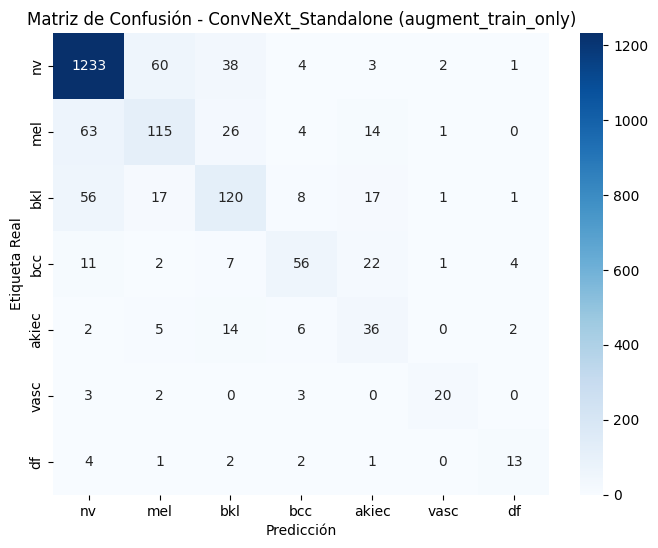


MATRIZ DE CONFUSIÓN: ConvNeXt_Standalone | Escenario: augment_all
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) a Train, Val y Test

Matriz (valores crudos):
[[1278   33   20    5    3    2    0]
 [  93   69   39    7    9    4    2]
 [  76   20  104    9    7    0    4]
 [  24    5   10   53    8    0    3]
 [   6    4   13   16   25    0    1]
 [   5    1    0    2    1   19    0]
 [   3    1    1    1    1    1   15]]


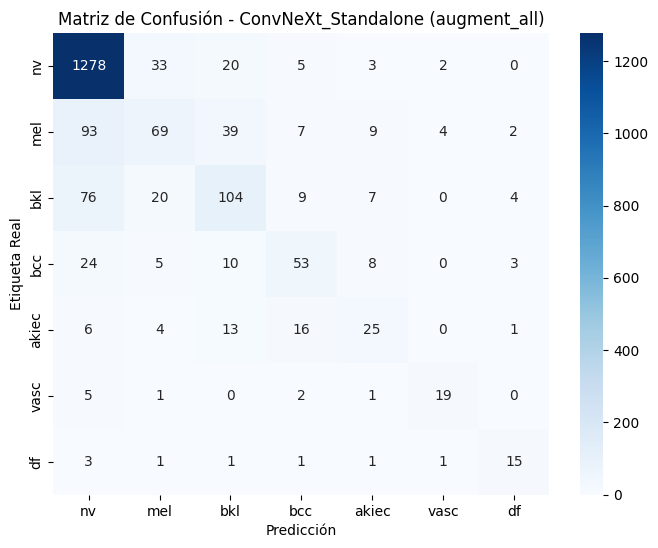


--- Matrices de Confusión generadas para todos los escenarios ---


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

MODEL_NAME = "ConvNeXt_Standalone"
MODEL_FN = get_convnext_standalone
BATCH_SIZE_HYBRID = 32

print("--- Iniciando Evaluación (Matrices de Confusión) ---")

if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Dispositivo definido: {device}")

# 1. Escenarios y pesos
escenarios_a_evaluar = {
    "augment_train_only": f"{CHECKPOINT_DIR}/{MODEL_NAME}_augment_train_only_best.pth",
    "augment_all": f"{CHECKPOINT_DIR}/{MODEL_NAME}_augment_all_best.pth"
}

# 2. Iterar escenarios
for scenario_name, path_pesos in escenarios_a_evaluar.items():

    print(f"\n{'='*40}")
    print(f"MATRIZ DE CONFUSIÓN: {MODEL_NAME} | Escenario: {scenario_name}")
    print(f"{'='*40}")

    if not os.path.exists(path_pesos):
        print(f"Aviso: No se encontró el archivo de pesos: {path_pesos}")
        continue

    # --- Obtener dataloader de test ---
    eval_loaders = get_dataloaders(
        augment_scenario=scenario_name,
        batch_size=BATCH_SIZE_HYBRID
    )
    test_loader = eval_loaders['test']

    # --- Cargar modelo ---
    model = MODEL_FN(num_classes=7)
    model.load_state_dict(torch.load(path_pesos, map_location=device))
    model = model.to(device)
    model.eval()

    # --- Obtener predicciones y labels ---
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Matriz de confusión ---
    cm = confusion_matrix(all_labels, all_preds)

    class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

    print("\nMatriz (valores crudos):")
    print(cm)

    # --- Matriz como heatmap ---
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de Confusión - {MODEL_NAME} ({scenario_name})")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Real")
    plt.show()

    # --- Liberar memoria ---
    del model
    del eval_loaders
    torch.cuda.empty_cache()

print("\n--- Matrices de Confusión generadas para todos los escenarios ---")

##12.2. Swin transformer

--- Iniciando Evaluación (Matrices de Confusión) ---

MATRIZ DE CONFUSIÓN: Swin_Standalone | Escenario: augment_train_only
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) SOLO a Train


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Matriz (valores crudos):
[[1301   29    8    2    0    1    0]
 [  44  161   10    3    3    1    1]
 [  21   14  168    5   11    0    1]
 [   7    1    6   85    3    1    0]
 [   6    3    5    6   45    0    0]
 [   0    3    0    1    0   24    0]
 [   2    1    0    0    1    0   19]]


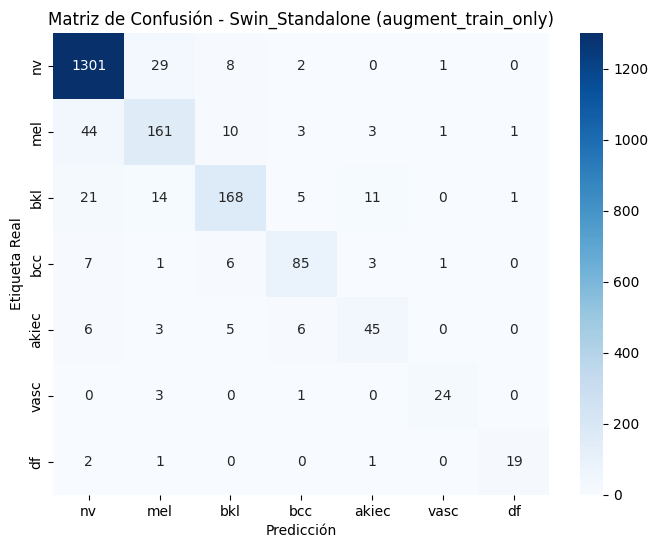


MATRIZ DE CONFUSIÓN: Swin_Standalone | Escenario: augment_all
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) a Train, Val y Test

Matriz (valores crudos):
[[1288   40    9    2    0    1    1]
 [  54  150   13    2    2    1    1]
 [  25   16  159    6   13    0    1]
 [   8    1    4   84    4    1    1]
 [   4    3    8    4   46    0    0]
 [   0    2    0    0    0   26    0]
 [   2    2    0    0    0    0   19]]


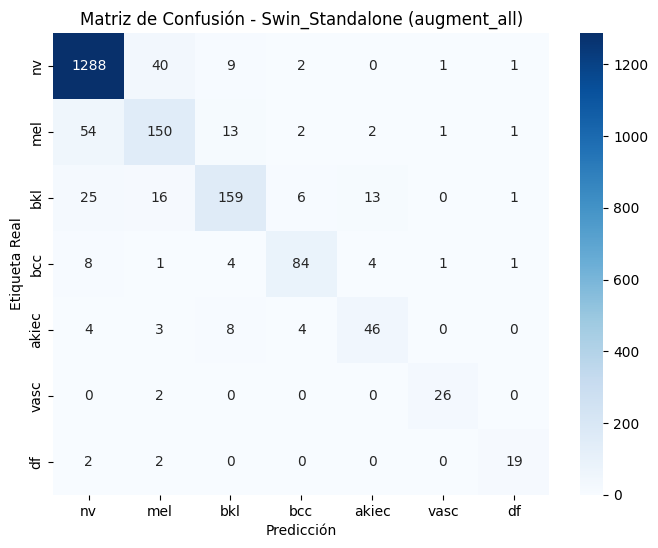


--- Matrices de Confusión generadas para todos los escenarios ---


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

MODEL_NAME = "Swin_Standalone"
MODEL_FN = get_swin_standalone
BATCH_SIZE_HYBRID = 32

print("--- Iniciando Evaluación (Matrices de Confusión) ---")

if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Dispositivo definido: {device}")

# 1. Escenarios y pesos
escenarios_a_evaluar = {
    "augment_train_only": f"{CHECKPOINT_DIR}/{MODEL_NAME}_augment_train_only_best.pth",
    "augment_all": f"{CHECKPOINT_DIR}/{MODEL_NAME}_augment_all_best.pth"
}

# 2. Iterar escenarios
for scenario_name, path_pesos in escenarios_a_evaluar.items():

    print(f"\n{'='*40}")
    print(f"MATRIZ DE CONFUSIÓN: {MODEL_NAME} | Escenario: {scenario_name}")
    print(f"{'='*40}")

    if not os.path.exists(path_pesos):
        print(f"Aviso: No se encontró el archivo de pesos: {path_pesos}")
        continue

    # --- Obtener dataloader de test ---
    eval_loaders = get_dataloaders(
        augment_scenario=scenario_name,
        batch_size=BATCH_SIZE_HYBRID
    )
    test_loader = eval_loaders['test']

    # --- Cargar modelo ---
    model = MODEL_FN(num_classes=7)
    model.load_state_dict(torch.load(path_pesos, map_location=device))
    model = model.to(device)
    model.eval()

    # --- Obtener predicciones y labels ---
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Matriz de confusión ---
    cm = confusion_matrix(all_labels, all_preds)

    class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

    print("\nMatriz (valores crudos):")
    print(cm)

    # --- Matriz como heatmap ---
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de Confusión - {MODEL_NAME} ({scenario_name})")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Real")
    plt.show()

    # --- Liberar memoria ---
    del model
    del eval_loaders
    torch.cuda.empty_cache()

print("\n--- Matrices de Confusión generadas para todos los escenarios ---")

##12.3. Híbrido

--- Iniciando Evaluación (Matrices de Confusión) ---

MATRIZ DE CONFUSIÓN: ConvNeXt_ST_AFF_Hybrid | Escenario: augment_train_only
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) SOLO a Train


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Matriz (valores crudos):
[[1290   34   13    1    1    1    1]
 [  48  155   15    1    2    1    1]
 [  25   19  164    3    9    0    0]
 [   6    3    2   86    4    0    2]
 [   4    4    4    5   47    0    1]
 [   2    3    0    2    0   21    0]
 [   2    1    0    0    1    0   19]]


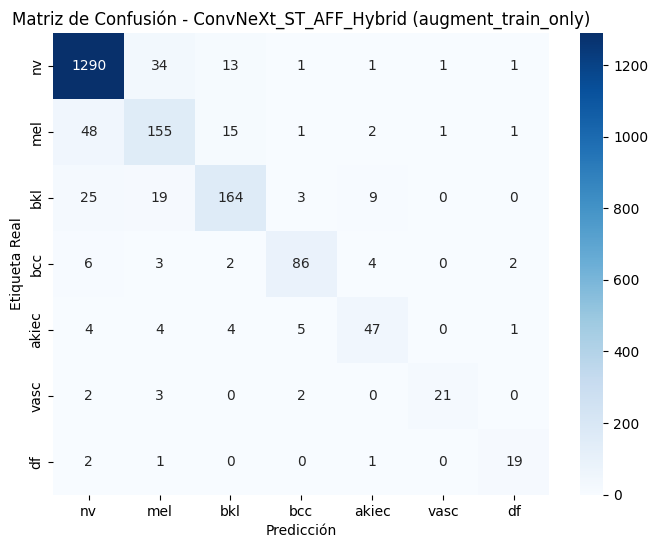


MATRIZ DE CONFUSIÓN: ConvNeXt_ST_AFF_Hybrid | Escenario: augment_all
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) a Train, Val y Test

Matriz (valores crudos):
[[1302   27    4    6    1    1    0]
 [  51  150   15    3    4    0    0]
 [  34   11  156    8   11    0    0]
 [   4    1    4   90    3    0    1]
 [   2    4    5    5   49    0    0]
 [   2    2    0    1    0   23    0]
 [   3    0    0    1    1    0   18]]


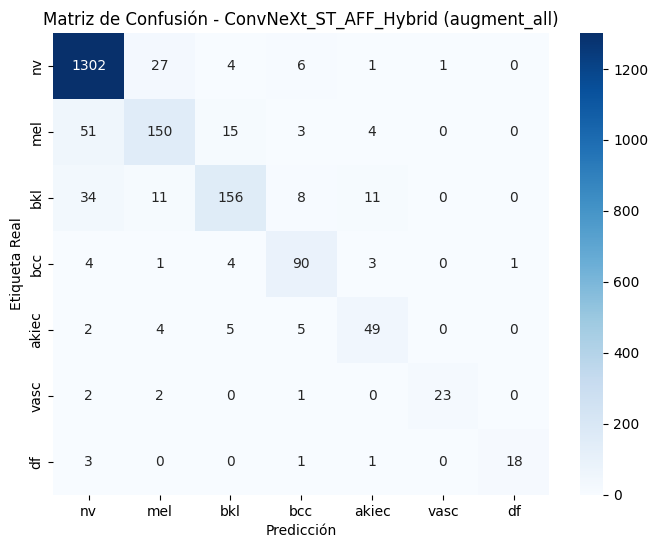


--- Matrices de Confusión generadas para todos los escenarios ---


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

MODEL_NAME = "ConvNeXt_ST_AFF_Hybrid"
MODEL_FN = ConvNeXt_ST_AFF
BATCH_SIZE_HYBRID = 16

print("--- Iniciando Evaluación (Matrices de Confusión) ---")

if 'device' not in locals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Dispositivo definido: {device}")

# 1. Escenarios y pesos
escenarios_a_evaluar = {
    "augment_train_only": f"{CHECKPOINT_DIR}/{MODEL_NAME}_augment_train_only_best.pth",
    "augment_all": f"{CHECKPOINT_DIR}/{MODEL_NAME}_augment_all_best.pth"
}

# 2. Iterar escenarios
for scenario_name, path_pesos in escenarios_a_evaluar.items():

    print(f"\n{'='*40}")
    print(f"MATRIZ DE CONFUSIÓN: {MODEL_NAME} | Escenario: {scenario_name}")
    print(f"{'='*40}")

    if not os.path.exists(path_pesos):
        print(f"Aviso: No se encontró el archivo de pesos: {path_pesos}")
        continue

    # --- Obtener dataloader de test ---
    eval_loaders = get_dataloaders(
        augment_scenario=scenario_name,
        batch_size=BATCH_SIZE_HYBRID
    )
    test_loader = eval_loaders['test']

    # --- Cargar modelo ---
    model = MODEL_FN(num_classes=7)
    model.load_state_dict(torch.load(path_pesos, map_location=device))
    model = model.to(device)
    model.eval()

    # --- Obtener predicciones y labels ---
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Matriz de confusión ---
    cm = confusion_matrix(all_labels, all_preds)

    class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

    print("\nMatriz (valores crudos):")
    print(cm)

    # --- Matriz como heatmap ---
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de Confusión - {MODEL_NAME} ({scenario_name})")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Real")
    plt.show()

    # --- Liberar memoria ---
    del model
    del eval_loaders
    torch.cuda.empty_cache()

print("\n--- Matrices de Confusión generadas para todos los escenarios ---")

#13. Curvas ROC


--- Iniciando generación de Curvas ROC ---

CURVAS ROC PARA: ConvNeXt_ST_AFF_Hybrid | Escenario: augment_train_only
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) SOLO a Train


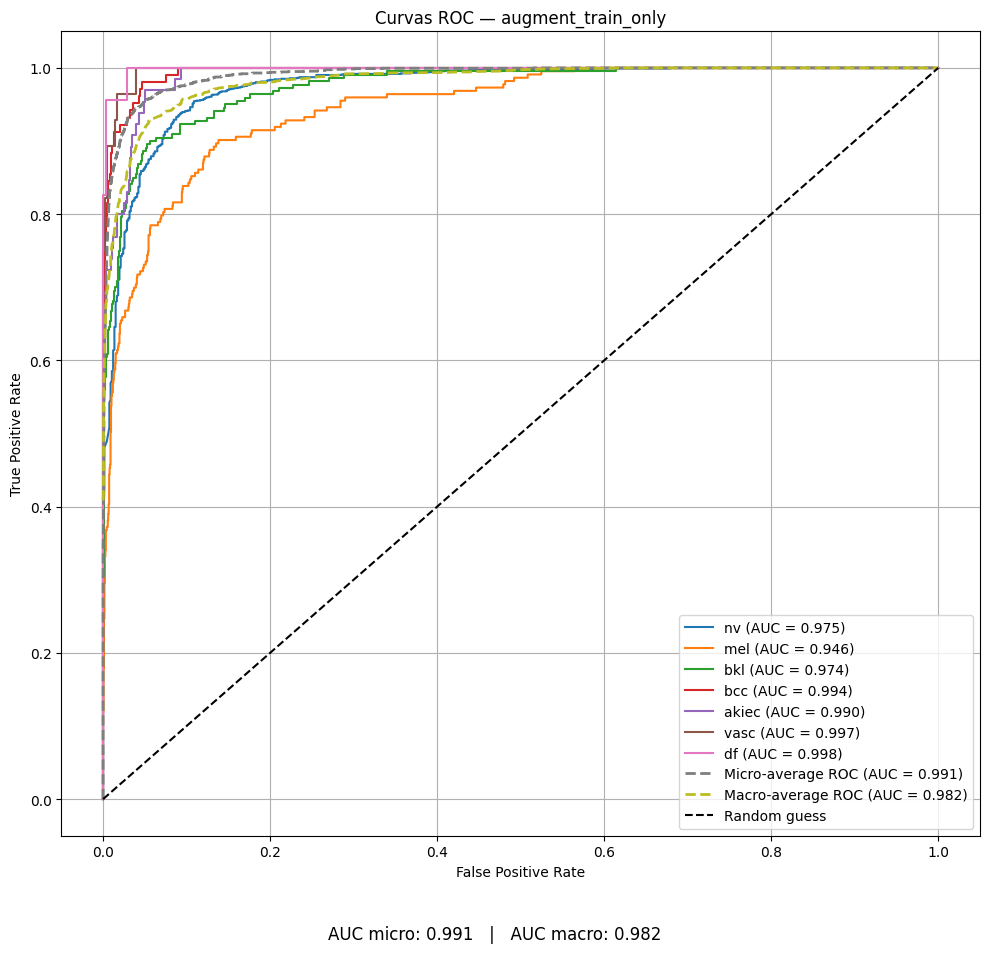


CURVAS ROC PARA: ConvNeXt_ST_AFF_Hybrid | Escenario: augment_all
Split Sizes -> Train: 6009 (60%), Val: 2003 (20%), Test: 2003 (20%)
Aplicando Data Augmentation (RandAugment) a Train, Val y Test


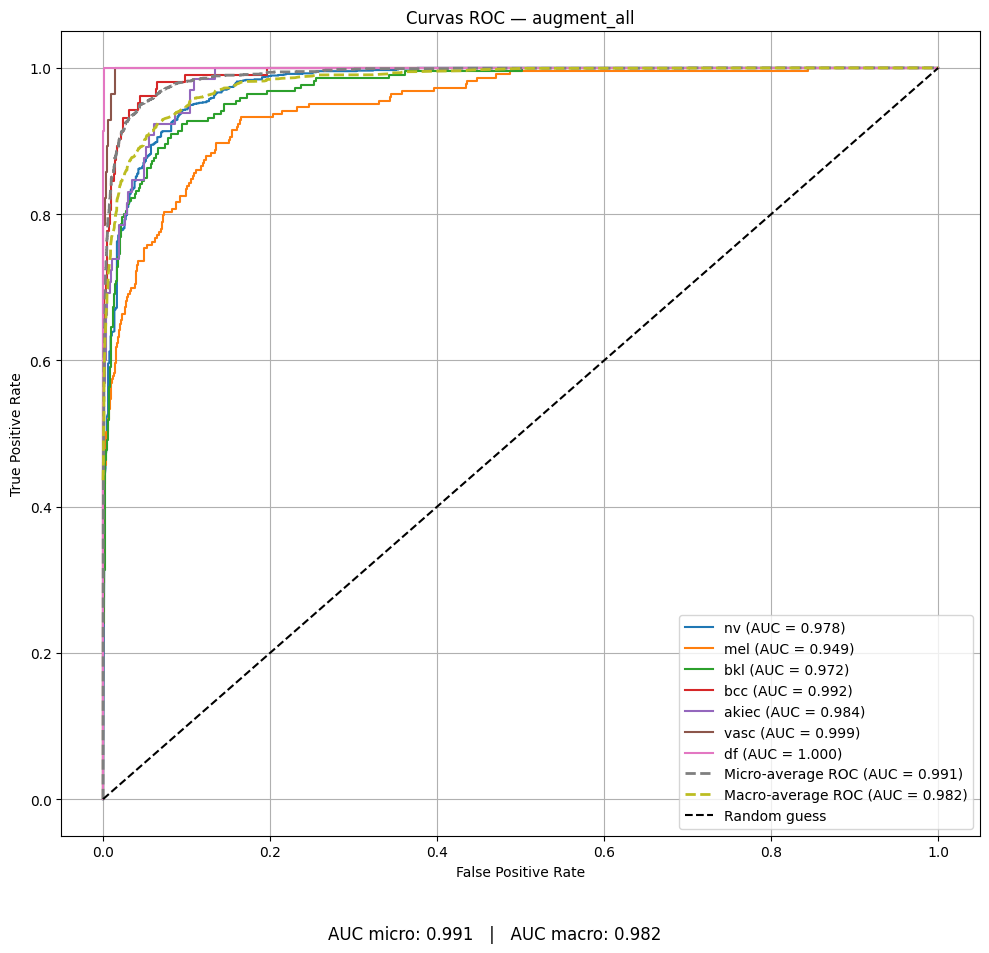


--- Curvas ROC generadas para todos los escenarios ---


In [ ]:
# ============================================
# CURVAS ROC POR ESCENARIO (macro, micro, por clase)
# ============================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

NUM_CLASSES = 7
CLASS_NAMES = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']


def plot_roc_curves(model, loader, scenario_name):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)                     # logits
            probs = torch.softmax(outputs, dim=1)       # convertir a probabilidades

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convertir listas a arrays
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Binarizar etiquetas para ROC multiclase
    y_true = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
    y_score = all_probs

    # Figura
    plt.figure(figsize=(10, 9))

    # Calcular ROC por clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                 label=f"{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})")

    # ROC micro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"],
             linestyle='--', linewidth=2,
             label=f"Micro-average ROC (AUC = {roc_auc['micro']:.3f})")

    # ROC macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= NUM_CLASSES
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr,
             linestyle='--', linewidth=2,
             label=f"Macro-average ROC (AUC = {roc_auc['macro']:.3f})")

    # Línea diagonal
    plt.plot([0, 1], [0, 1], 'k--', label="Random guess")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curvas ROC — {scenario_name}")
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.figtext(
        0.5, -0.05,
        f"AUC micro: {roc_auc['micro']:.3f}   |   AUC macro: {roc_auc['macro']:.3f}",
        ha="center", fontsize=12
    )

    plt.tight_layout()
    plt.show()

# =================================================
# EVALUAR AMBOS ESCENARIOS
# =================================================

print("\n--- Iniciando generación de Curvas ROC ---")

for scenario_name, path_pesos in escenarios_a_evaluar.items():

    print(f"\n{'='*60}")
    print(f"CURVAS ROC PARA: {MODEL_NAME} | Escenario: {scenario_name}")
    print(f"{'='*60}")

    if not os.path.exists(path_pesos):
        print(f"Aviso: No se encontró {path_pesos}. Saltando.")
        continue

    # Cargar el dataloader correcto para test
    eval_loaders = get_dataloaders(
        augment_scenario=scenario_name,
        batch_size=BATCH_SIZE_HYBRID
    )
    test_loader = eval_loaders['test']

    # Instanciar modelo y cargar pesos
    model = MODEL_FN(num_classes=7)
    model.load_state_dict(torch.load(path_pesos, map_location=device))
    model = model.to(device)

    # Generar curvas ROC
    plot_roc_curves(model, test_loader, f"{scenario_name}")

    # Limpiar
    del model
    del test_loader
    torch.cuda.empty_cache()

print("\n--- Curvas ROC generadas para todos los escenarios ---")